# 0 Loads and Imports

In [1]:
#Imports
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.metrics import mean_squared_log_error

from learntools.time_series.utils import plot_periodogram, seasonal_plot
from learntools.time_series.utils import make_lags, make_leads, make_multistep_target



# matplotlib defaults
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",          
    style=".-",               
    markeredgecolor="0.25", 
    markerfacecolor="0.25", 
    legend=True            
)

%config InlineBackend.figure_format = 'retina'



In [2]:
#Loads
stores_dir = Path('../../Documents/Gergely dolgok/AI/0 Datasets/Time Series/Stores Demo')
dtrain = pd.read_csv(stores_dir/'train.csv',
                     usecols = ['date', 'store_nbr', 'family', 'sales', 'onpromotion'],
                     dtype = {'store_nbr':'category',
                              'family':'category',
                              'sales':'float32',
                              'onpromotion':'uint32'},
                     parse_dates = ['date'],
                     infer_datetime_format = True)

dtrain['date'] = dtrain['date'].dt.to_period('D')
dtrain = dtrain.set_index(['date', 'family', 'store_nbr']).sort_index()

#test:
dtest = pd.read_csv(stores_dir/'test.csv',
                    usecols = ['date', 'store_nbr', 'family', 'id', 'onpromotion'],
                    dtype = {'store_nbr':'category',
                             'family':'category',
                             'onpromotion':'uint32'},
                    parse_dates = ['date'],
                    infer_datetime_format = True)
dtest['date'] = dtest['date'].dt.to_period('D')
dtest = dtest.set_index(['date', 'family', 'store_nbr']).sort_index()

#holidays:
holidays = pd.read_csv(stores_dir/'holidays_events.csv',
                       dtype = {'type':'category',
                                'locale':'category',
                                'locale_name':'category',
                                'description':'category',
                                'transferred':'bool'},
                       parse_dates = ['date'],
                       infer_datetime_format = True)
holidays = holidays.set_index('date').to_period('D')
dtest.head()

id  onpromotion
date       family     store_nbr                      
2017-08-16 AUTOMOTIVE 1          3000888            0
                      10         3000921            0
                      11         3000954            0
                      12         3000987            0
                      13         3001020            0

In [3]:
#data sets stats:
num_fams = len(dtrain.index.get_level_values(level=1).unique())
num_stores = len(dtrain.index.get_level_values(level=2).unique())
print(f"Number of families: {num_fams}, and number of stores: {num_stores}")
display(dtrain)

Number of families: 33, and number of stores: 54


sales  onpromotion
date       family     store_nbr                        
2013-01-01 AUTOMOTIVE 1           0.000000            0
                      10          0.000000            0
                      11          0.000000            0
                      12          0.000000            0
                      13          0.000000            0
...                                    ...          ...
2017-08-15 SEAFOOD    54          3.000000            0
                      6          47.575001            0
                      7          46.507000            0
                      8          23.330000            0
                      9          16.000000            0

[3000888 rows x 2 columns]

# 1 Get Data Sets

In [4]:
fam = dtrain.index.get_level_values(level = 1).unique()
fam

CategoricalIndex(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
                  'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI',
                  'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II',
                  'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
                  'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR',
                  'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER',
                  'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES',
                  'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
                  'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
                 categories=['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', ..., 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'], ordered=False, dtype='category', name='family')

In [5]:
X_train = dtrain.copy()
y_train = X_train.unstack(['family', 'store_nbr']).loc[:, 'sales']
y_train_stacked = pd.Series(y_train.stack(['family', 'store_nbr']), name = 'sales')

#default parameters
STORE = '1'
FAMILY = 'BREAD/BAKERY'
START = '2016-01-01'
END = '2016-06-15'

index_ = y_train.index.get_level_values(0).unique()

#One Store One family
y_true = (y_train.stack(['family', 'store_nbr'])
                 .to_frame()
                 .query("family == @FAMILY and store_nbr == @STORE")
                 .reset_index(['family', 'store_nbr'], drop = True)
                 .rename(columns = {0:'ground_truth'})
                 .loc[START:END]
                 .squeeze()
                 
                 )
y_train_stacked

date        family      store_nbr
2013-01-01  AUTOMOTIVE  1             0.000000
                        10            0.000000
                        11            0.000000
                        12            0.000000
                        13            0.000000
                                       ...    
2017-08-15  SEAFOOD     54            3.000000
                        6            47.575001
                        7            46.507000
                        8            23.330000
                        9            16.000000
Name: sales, Length: 3000888, dtype: float32

# 2 Trend

In [6]:
#X_trend
from statsmodels.tsa.deterministic import DeterministicProcess
dp = DeterministicProcess(
                index = index_,
                constant = True,
                order = 1,
                drop = True
                )
X_trend = dp.in_sample()
#X_trend.head()

In [7]:
#X_trend_test
test_index = dtest.index.get_level_values(0).unique()
test_len = len(test_index)
X_trend_test = dp.out_of_sample(test_len)

In [8]:
#y_trend_fit
from sklearn.linear_model import LinearRegression
model_trend = LinearRegression(fit_intercept = False)
model_trend.fit(X_trend, y_train)
#y_trend_fit
y_trend_fit = pd.DataFrame(model_trend.predict(X_trend), index = X_trend.index, columns = y_train.columns)
y_trend_fit_stacked = pd.Series(y_trend_fit.stack(['family', 'store_nbr']), name = 'y_fit')
y_trend_fit_stacked = y_trend_fit_stacked.clip(0.0)
#y_pred
y_trend_pred = pd.DataFrame(model_trend.predict(X_trend_test), index = X_trend_test.index, columns = y_train.columns)
y_trend_pred = y_trend_pred.clip(0.0)
#y_pred_stacked
y_trend_pred_stacked = y_trend_pred.stack(['family', 'store_nbr']).to_frame().rename(columns = {0:'sales_prediction'})
y_trend_pred_stacked.index = y_trend_pred_stacked.index.set_names('date', level = 0)

In [9]:
#Check Function

def check (X,
           y = dtrain,
           model = None,
           FAMILY = FAMILY,
           STORE = STORE,
           START = START,
           END = END):
    
    #Y
    if y is dtrain:
        y = (dtrain.query("family == @FAMILY")           #Sales Average for 1 family and all the stores
                   .groupby('date')['sales'].mean()
                   .loc[START:END]
            )
        title = f'Average Sales from {START} to {END} for {FAMILY}'
             
    else:
        y = (y.stack([0, 1])                      #1 Store and 1 Family only
                    .to_frame()
                    .query("family == @FAMILY and store_nbr == @STORE")
                    .reset_index(['family', 'store_nbr'], drop = True)
                    .loc[START: END]
                    .rename(columns = {0:'ground_truth'})
                    .squeeze()
             )
        
        title = f'Sales from {START} to {END} for {FAMILY} and for Store {STORE}'
    
    #X
    X_check = X.loc[START:END]
    
    #Model
    if model:
        model_ = model
    
    else:
        model_ = LinearRegression(fit_intercept = False)
        
    #y_fit
    model_.fit(X_check, y)
    y_fit = pd.Series(model_.predict(X_check), index = X_check.index, name = "y_fit").clip(0.0)
    
    #Rmsle
    rmsle = np.sqrt(mean_squared_log_error(y, y_fit))
    print(f"RMSLE: {rmsle:.5f}")
    
    #Plot
    axs = y.plot(**plot_params, alpha = 0.5, title = title)
    _ = y_fit.plot(ax = axs, color = 'C0', linewidth = 2.5)
    axs.legend();



RMSLE: 0.32976


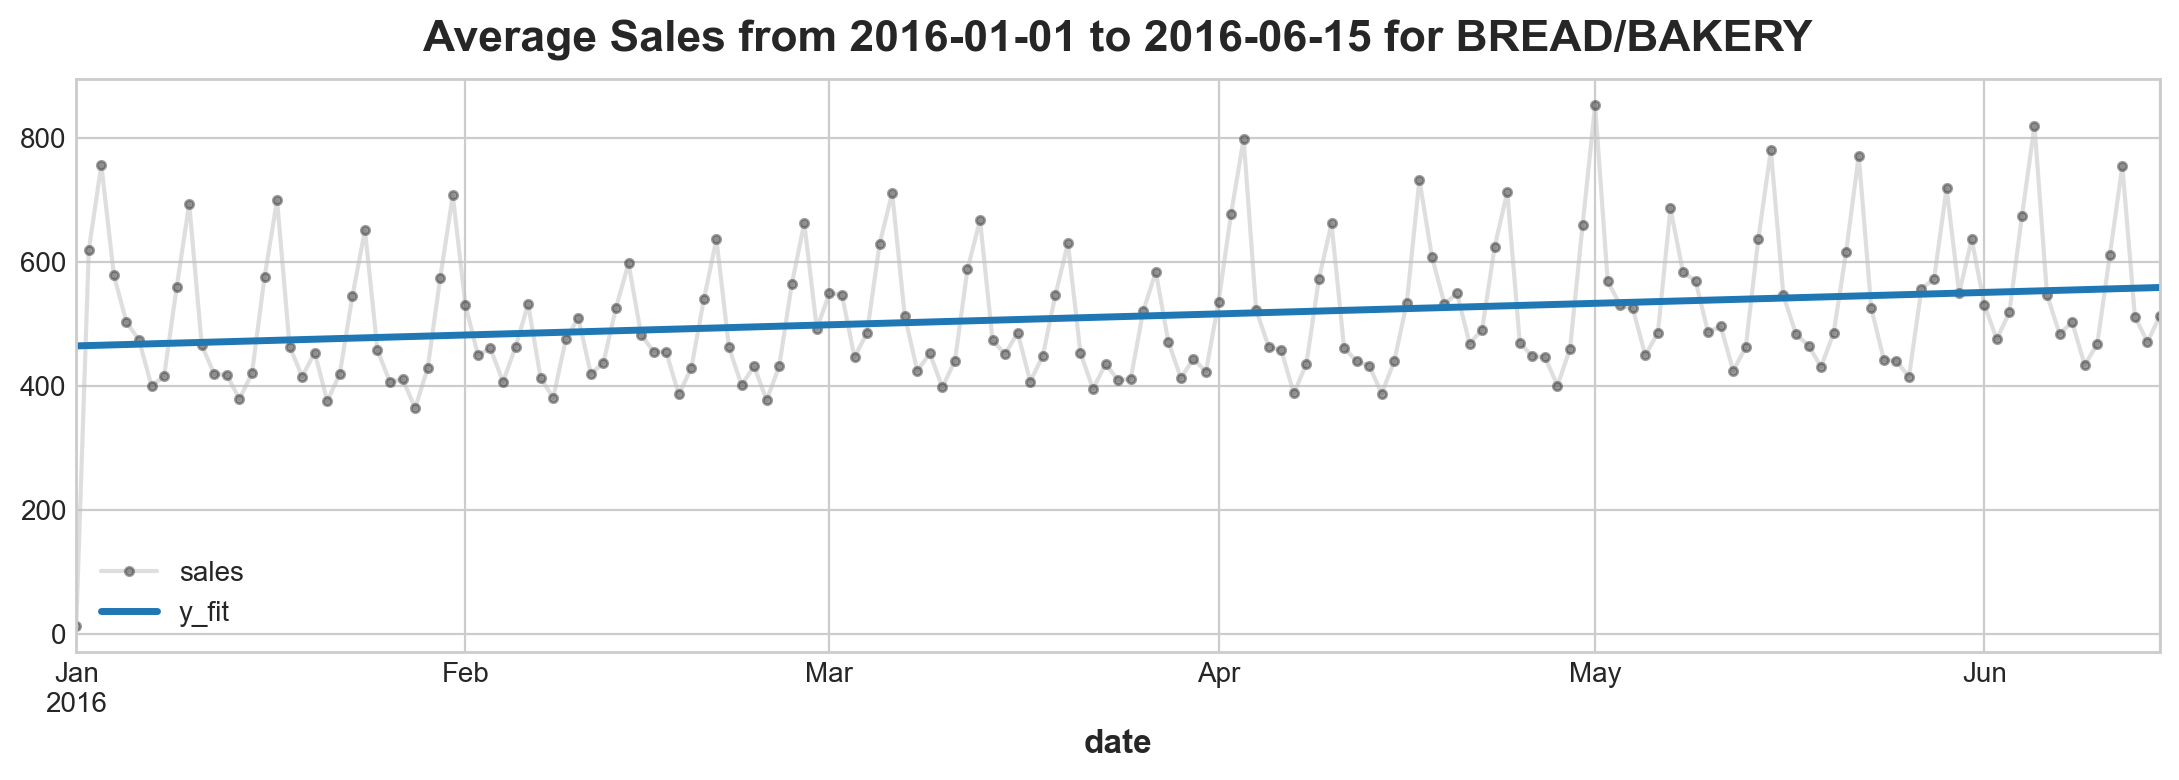

In [10]:
#Call check function
check(X_trend)

In [11]:
#y_trend_true
y_trend_fit_true = (y_trend_fit
               .stack(['family', 'store_nbr'])
               .to_frame()
               .query("family == @FAMILY and store_nbr == @STORE")
               .reset_index(['family', 'store_nbr'], drop = True)
               .rename(columns = {0:'y_trend_fit'})
               .loc[START:END]
               
               )

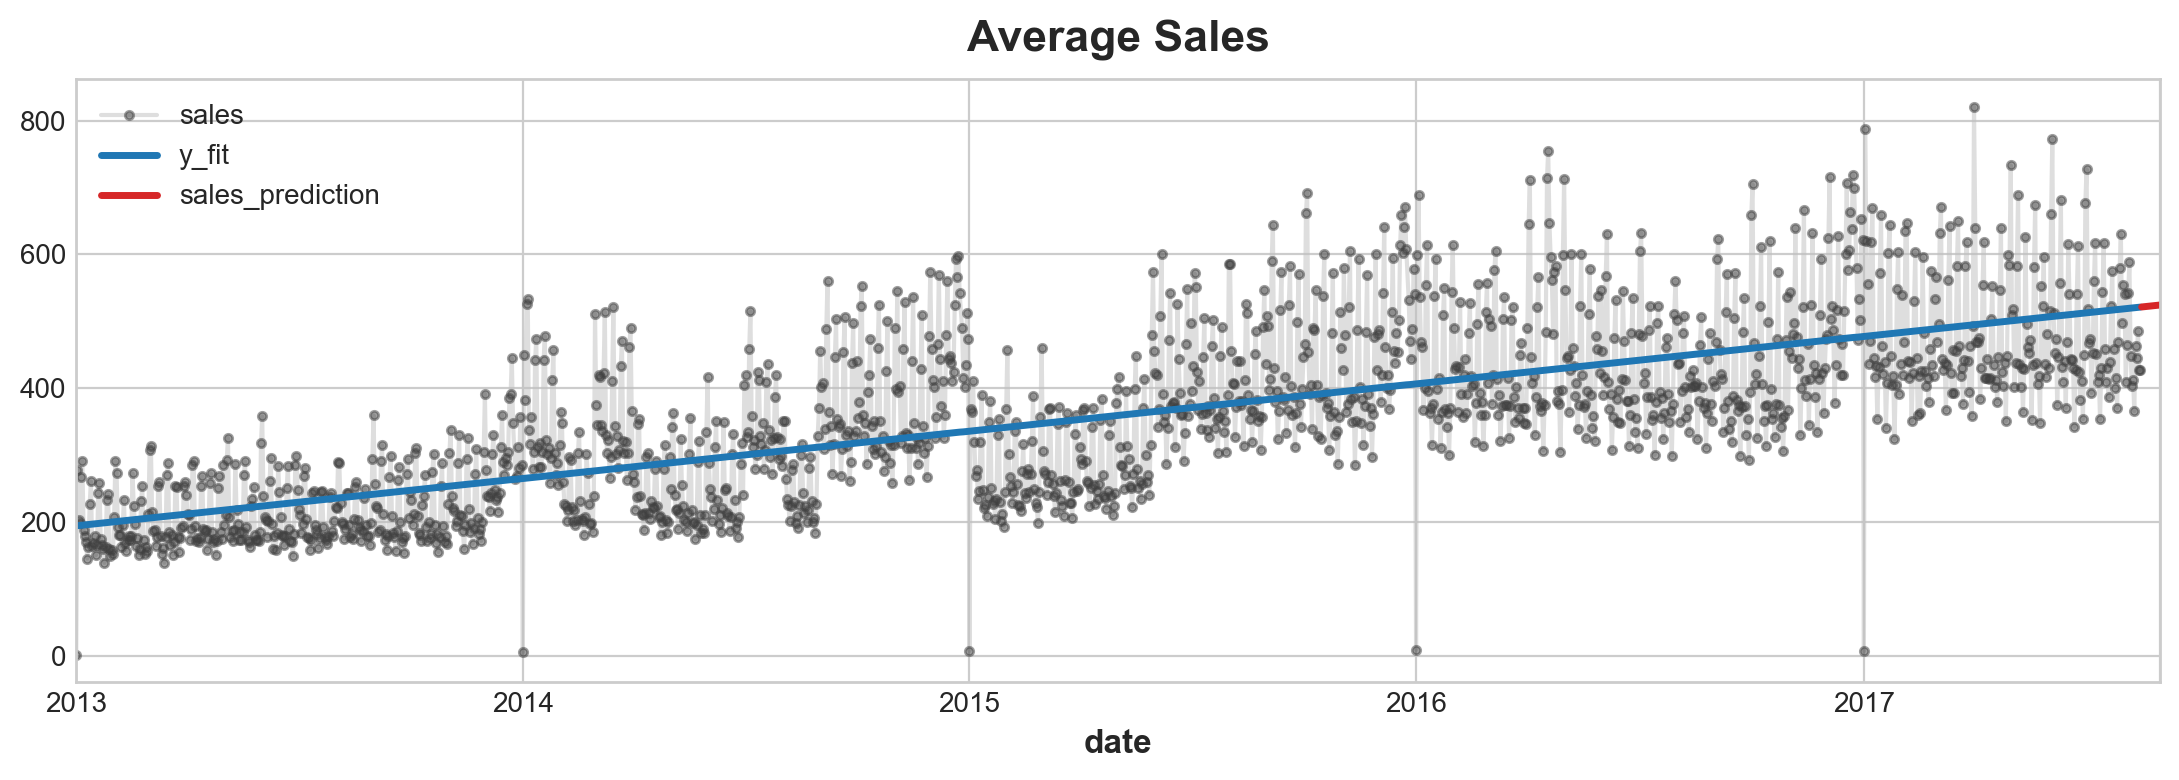

In [12]:
#Plot full period
sales_averages = dtrain.groupby('date')['sales'].mean()
sales_averages_pred = y_trend_pred_stacked.groupby('date')['sales_prediction'].mean()
model_trend.fit(X_trend, sales_averages)
sa_fit = pd.Series(model_trend.predict(X_trend), index = X_trend.index, name = 'y_fit')

axs = sales_averages.plot(**plot_params, alpha = 0.5, title = "Average Sales")
_ = sa_fit.plot(ax = axs, color = 'C0', linewidth = 2.5)
_ = sales_averages_pred.plot(ax = axs, color = 'C3', linewidth = 2.5)
axs.legend();

### Measurements and Outputs

In [13]:
#Rmse
from sklearn.metrics import mean_squared_log_error
rmse_trend = np.sqrt(mean_squared_log_error(y_train_stacked, y_trend_fit_stacked))
rmse_trend #Larger than in the check function, because this apply to the whole period not just for the first half of 2016!

1.1853832748968156

In [14]:
#output
output = dtest.copy()
output['sales'] = y_trend_pred_stacked['sales_prediction']
output = output.set_index('id')['sales']
output.to_csv('sales_prediction1.csv')

# 2.5 Polynomial

In [15]:
dp2 = DeterministicProcess(
                    index = index_,
                    constant = True,
                    order = 3,
                    drop = True

)


X_poly = dp2.in_sample()
X_poly_test = dp2.out_of_sample(test_len)
X_poly_test

,const,trend,trend_squared,trend_cubed
2017-08-16,1.0,1685.0,2839225.0,4.784094e+09
2017-08-17,1.0,1686.0,2842596.0,4.792617e+09
2017-08-18,1.0,1687.0,2845969.0,4.801150e+09
2017-08-19,1.0,1688.0,2849344.0,4.809693e+09
2017-08-20,1.0,1689.0,2852721.0,4.818246e+09
2017-08-21,1.0,1690.0,2856100.0,4.826809e+09
2017-08-22,1.0,1691.0,2859481.0,4.835382e+09
2017-08-23,1.0,1692.0,2862864.0,4.843966e+09
2017-08-24,1.0,1693.0,2866249.0,4.852560e+09
2017-08-25,1.0,1694.0,2869636.0,4.861163e+09


RMSLE: 0.33182


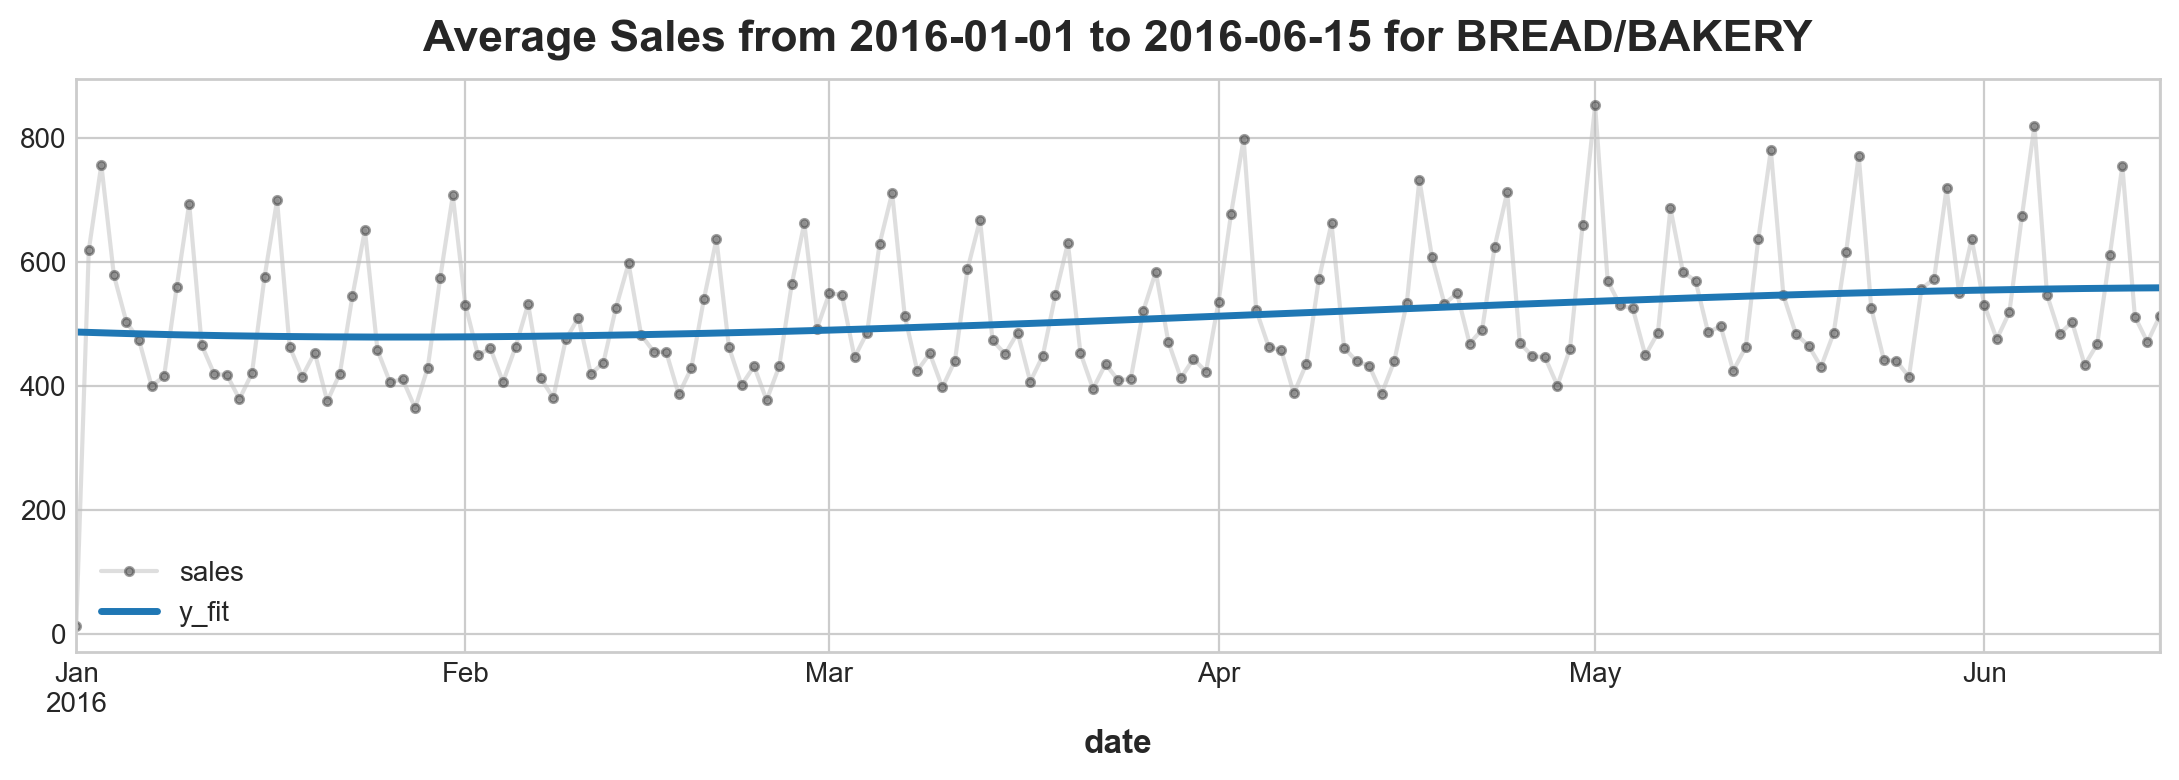

In [16]:
check(X_poly)

In [17]:
#Prediction
model_trend.fit(X_poly, y_train)
y_poly_fit = pd.DataFrame(model_trend.predict(X_poly), index = X_poly.index, columns = y_train.columns).clip(0.0)
y_poly_pred = pd.DataFrame(model_trend.predict(X_poly_test), index = X_poly_test.index, columns = y_train.columns).clip(0.0)
y_poly_pred_stacked = y_poly_pred.stack([0, 1]).to_frame().rename(columns = {0:'sales_predictions'})
y_poly_fit_stacked = y_poly_fit.stack([0, 1]).to_frame().rename(columns = {0:'y_fit'})

In [18]:
#Pred for 90 days
X_poly_test_90 = dp2.out_of_sample(500)
y_poly_pred_90 = pd.DataFrame(model_trend.predict(X_poly_test_90), index = X_poly_test_90.index, columns = y_train.columns)
y_poly_pred_90.index.name = 'date'
y_poly_pred_90_stacked = y_poly_pred_90.stack([0, 1]).to_frame().rename(columns = {0: 'sales_predictions'})
sa_poly_90 = y_poly_pred_90_stacked.groupby('date')['sales_predictions'].mean()

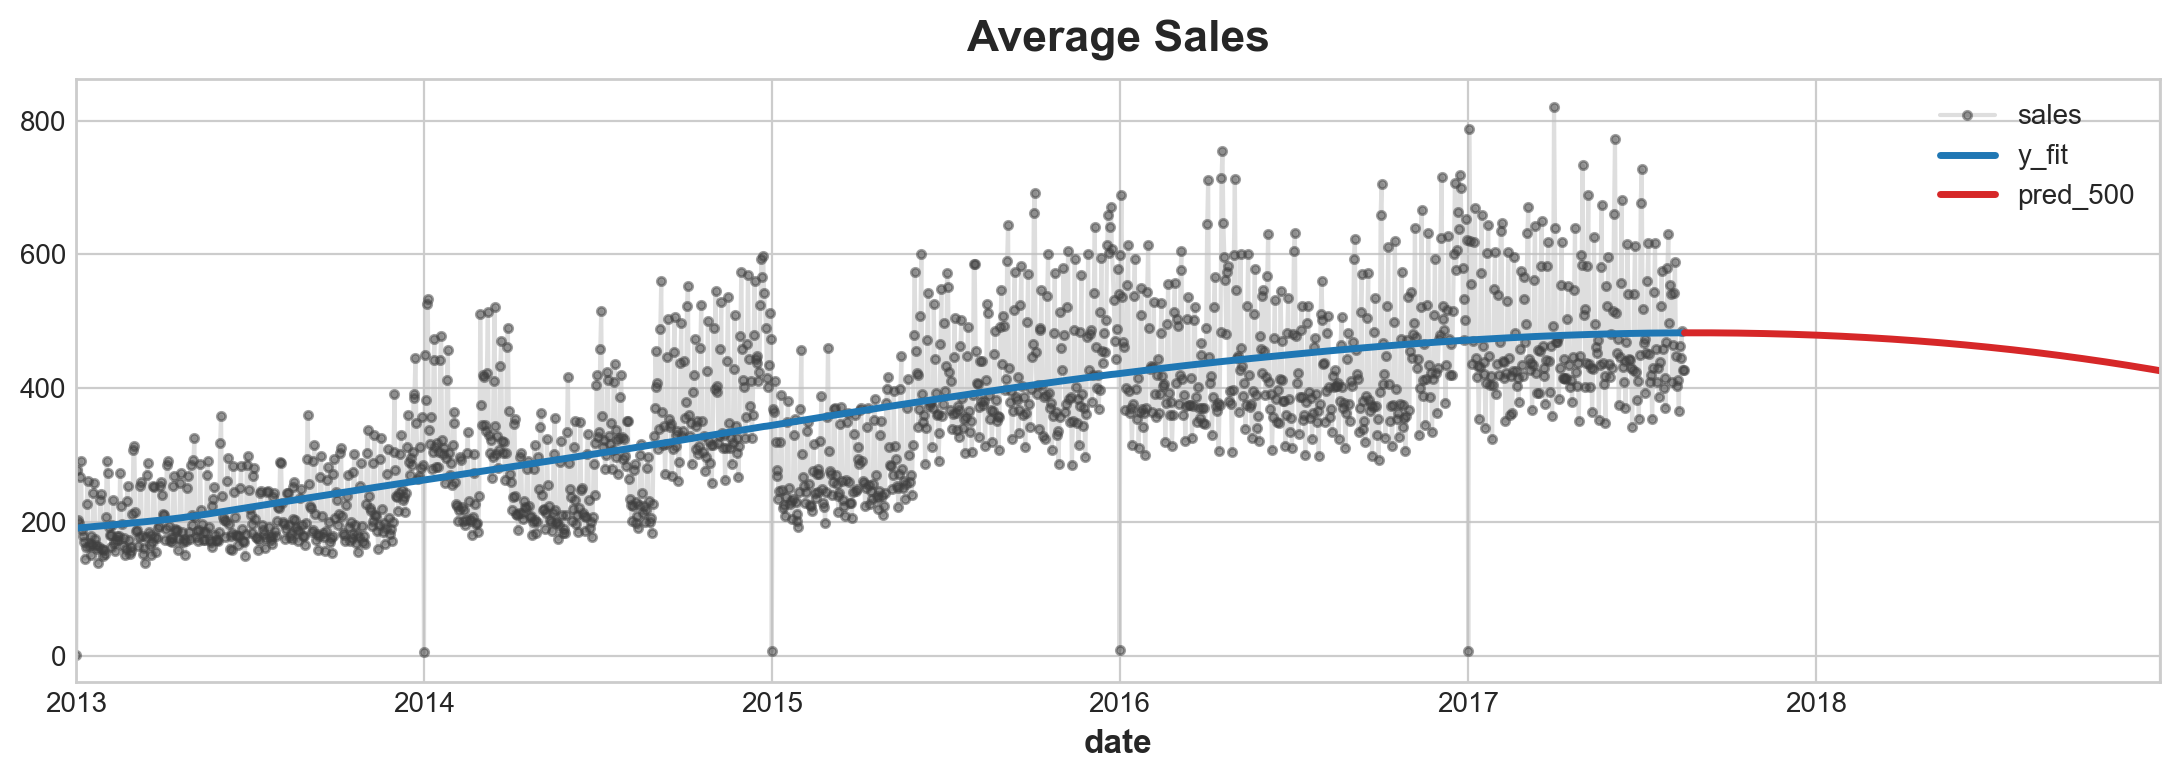

In [19]:
#Average Sales Plot
sap_fit = y_poly_fit_stacked.groupby('date')['y_fit'].mean()
axs = sales_averages.plot(**plot_params, alpha = 0.5, title = 'Average Sales')
_ = sap_fit.plot(ax = axs, color = 'C0', linewidth = 2.5)
_ = sa_poly_90.plot(ax = axs, color = 'C3', linewidth = 2.5, label = 'pred_500')
axs.legend();

In [20]:
#Output
output2 = dtest.copy()
output2['sales_predictions'] = y_poly_pred_stacked['sales_predictions']
output2 = output2.set_index('id')['sales_predictions']
output2.to_csv('sales_predictions2.csv')

# 3 Seasonality

In [21]:
#weekly
#annual/monthly - periodogram
#special events - holidays, volcano

In [22]:
dtrain.index.get_level_values(1).unique()

CategoricalIndex(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
                  'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI',
                  'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II',
                  'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
                  'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR',
                  'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER',
                  'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES',
                  'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
                  'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
                 categories=['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', ..., 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'], ordered=False, dtype='category', name='family')

In [23]:
#Params
STORE = '1'
FAMILY = 'BREAD/BAKERY'

#y
y_tr = (y_train.stack([0, 1])
               .to_frame()
               .query("family == @FAMILY and store_nbr == @STORE")
               .reset_index(['family', 'store_nbr'], drop = True)
               .rename(columns = {0:'ground_truth'})
               .loc[START:END]
               .squeeze()        
       
       )
y_tr = y_tr.to_frame()
y_tr['day'] = y_tr.index.day_of_week
y_tr['week'] = y_tr.index.week
y_tr

,ground_truth,day,week
date,,,
2016-01-01,0.000000,4,53
2016-01-02,259.811005,5,53
2016-01-03,138.274994,6,53
2016-01-04,552.171997,0,1
2016-01-05,461.738007,1,1
...,...,...,...
2016-06-11,417.851990,5,23
2016-06-12,183.319000,6,23
2016-06-13,462.028992,0,24


C:\Users\banya\AppData\Local\Programs\Python\Python311\Lib\site-packages\learntools-0.3.4-py3.11.egg\learntools\time_series\utils.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.



<AxesSubplot: title={'center': 'Seasonal Plot (week/day)'}, xlabel='day', ylabel='ground_truth'>

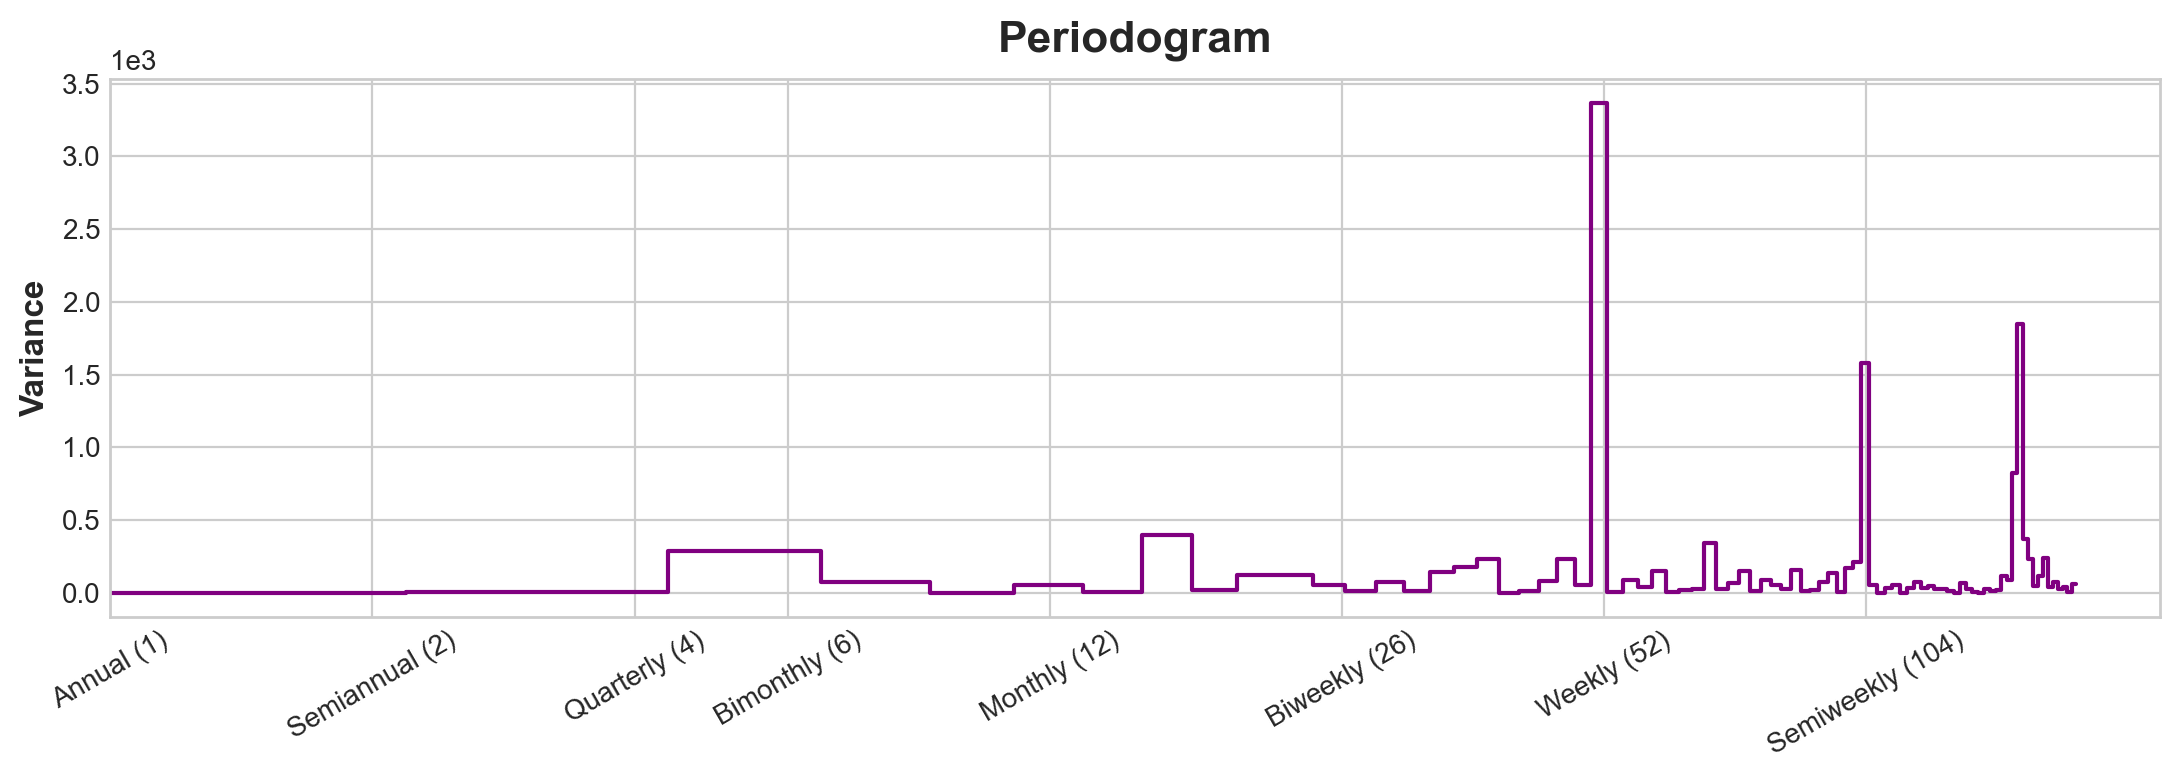

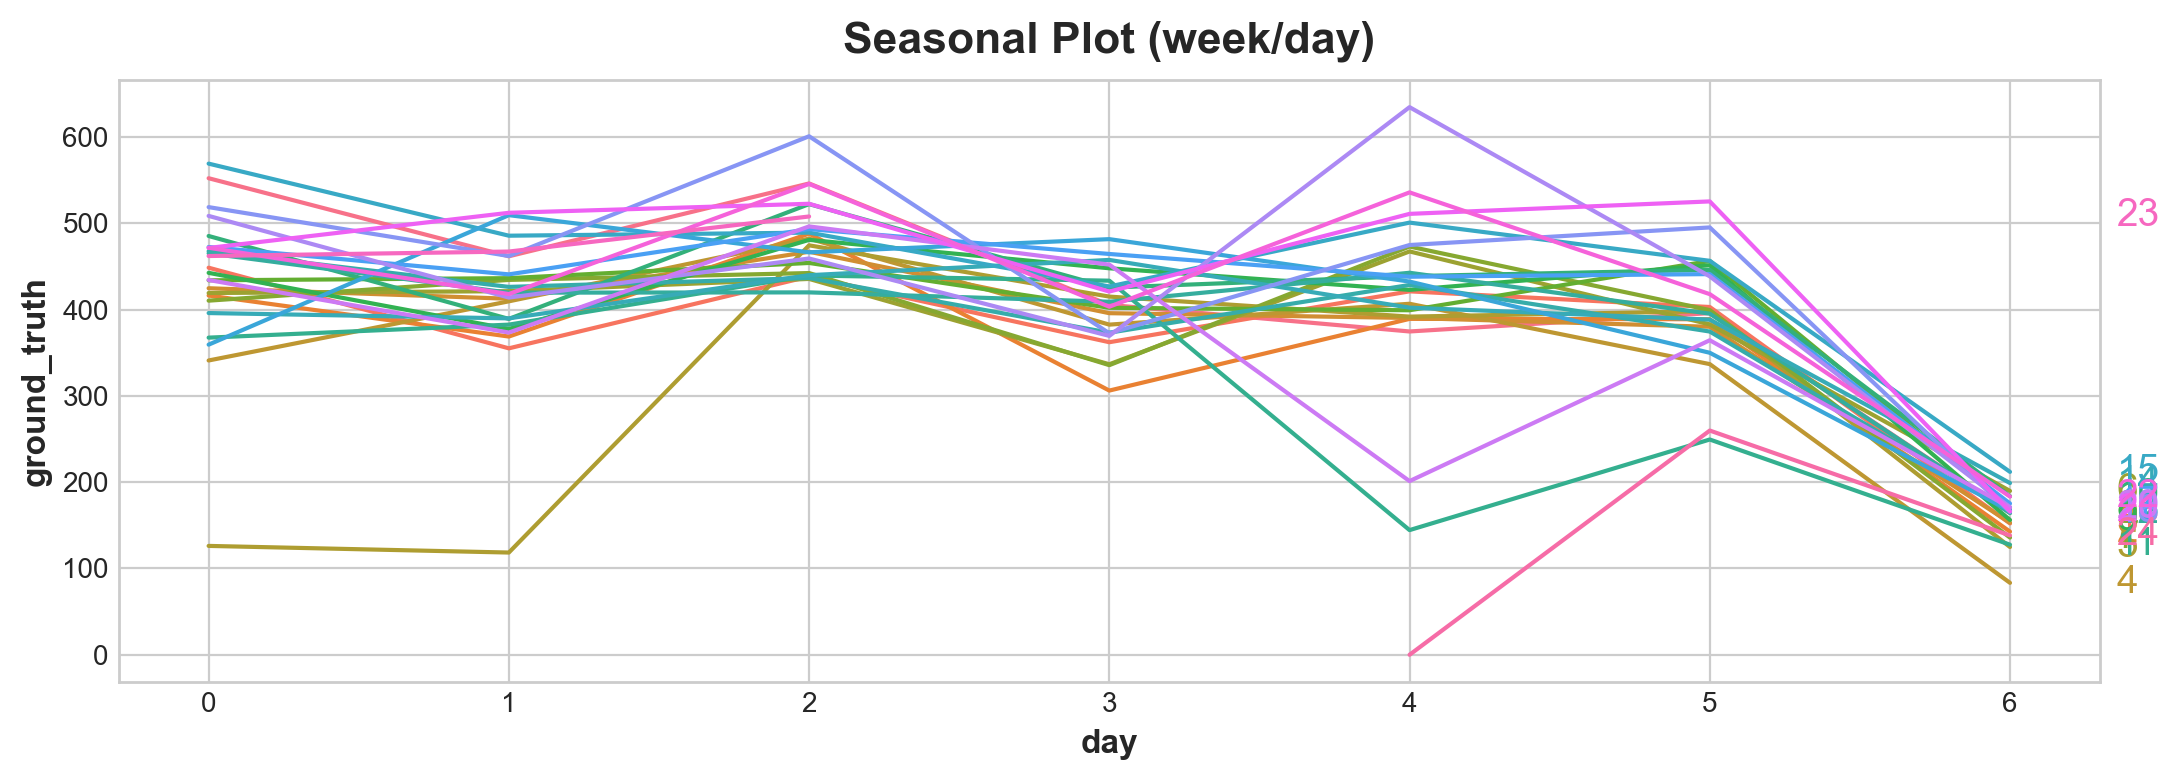

In [24]:
#Plot periodogram - Annaul, monthly seasonality
from learntools.time_series.utils import plot_periodogram, seasonal_plot
plot_periodogram(y_tr['ground_truth'])

#Plot weekly seasonality
seasonal_plot(y_tr, y = 'ground_truth', period = 'week', freq = 'day')

### Get weekly data

In [25]:
#dummies
X_s = X_trend.copy()
X_s['day'] = X_trend.index.day_of_week
X_weekly = pd.get_dummies(X_s['day'], prefix = 'day_of_week_')
X_weekly

,day_of_week__0,day_of_week__1,day_of_week__2,day_of_week__3,day_of_week__4,day_of_week__5,day_of_week__6
date,,,,,,,
2013-01-01,0,1,0,0,0,0,0
2013-01-02,0,0,1,0,0,0,0
2013-01-03,0,0,0,1,0,0,0
2013-01-04,0,0,0,0,1,0,0
2013-01-05,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...
2017-08-11,0,0,0,0,1,0,0
2017-08-12,0,0,0,0,0,1,0
2017-08-13,0,0,0,0,0,0,1


In [26]:
#Join the two tables
X_seasonal = X_s.join(X_weekly).drop('day', axis = 1)
print(X_seasonal.shape)
display(X_seasonal)

(1684, 9)


,const,trend,day_of_week__0,day_of_week__1,day_of_week__2,day_of_week__3,day_of_week__4,day_of_week__5,day_of_week__6
date,,,,,,,,,
2013-01-01,1.0,1.0,0,1,0,0,0,0,0
2013-01-02,1.0,2.0,0,0,1,0,0,0,0
2013-01-03,1.0,3.0,0,0,0,1,0,0,0
2013-01-04,1.0,4.0,0,0,0,0,1,0,0
2013-01-05,1.0,5.0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,1680.0,0,0,0,0,1,0,0
2017-08-12,1.0,1681.0,0,0,0,0,0,1,0
2017-08-13,1.0,1682.0,0,0,0,0,0,0,1


RMSLE: 0.27609


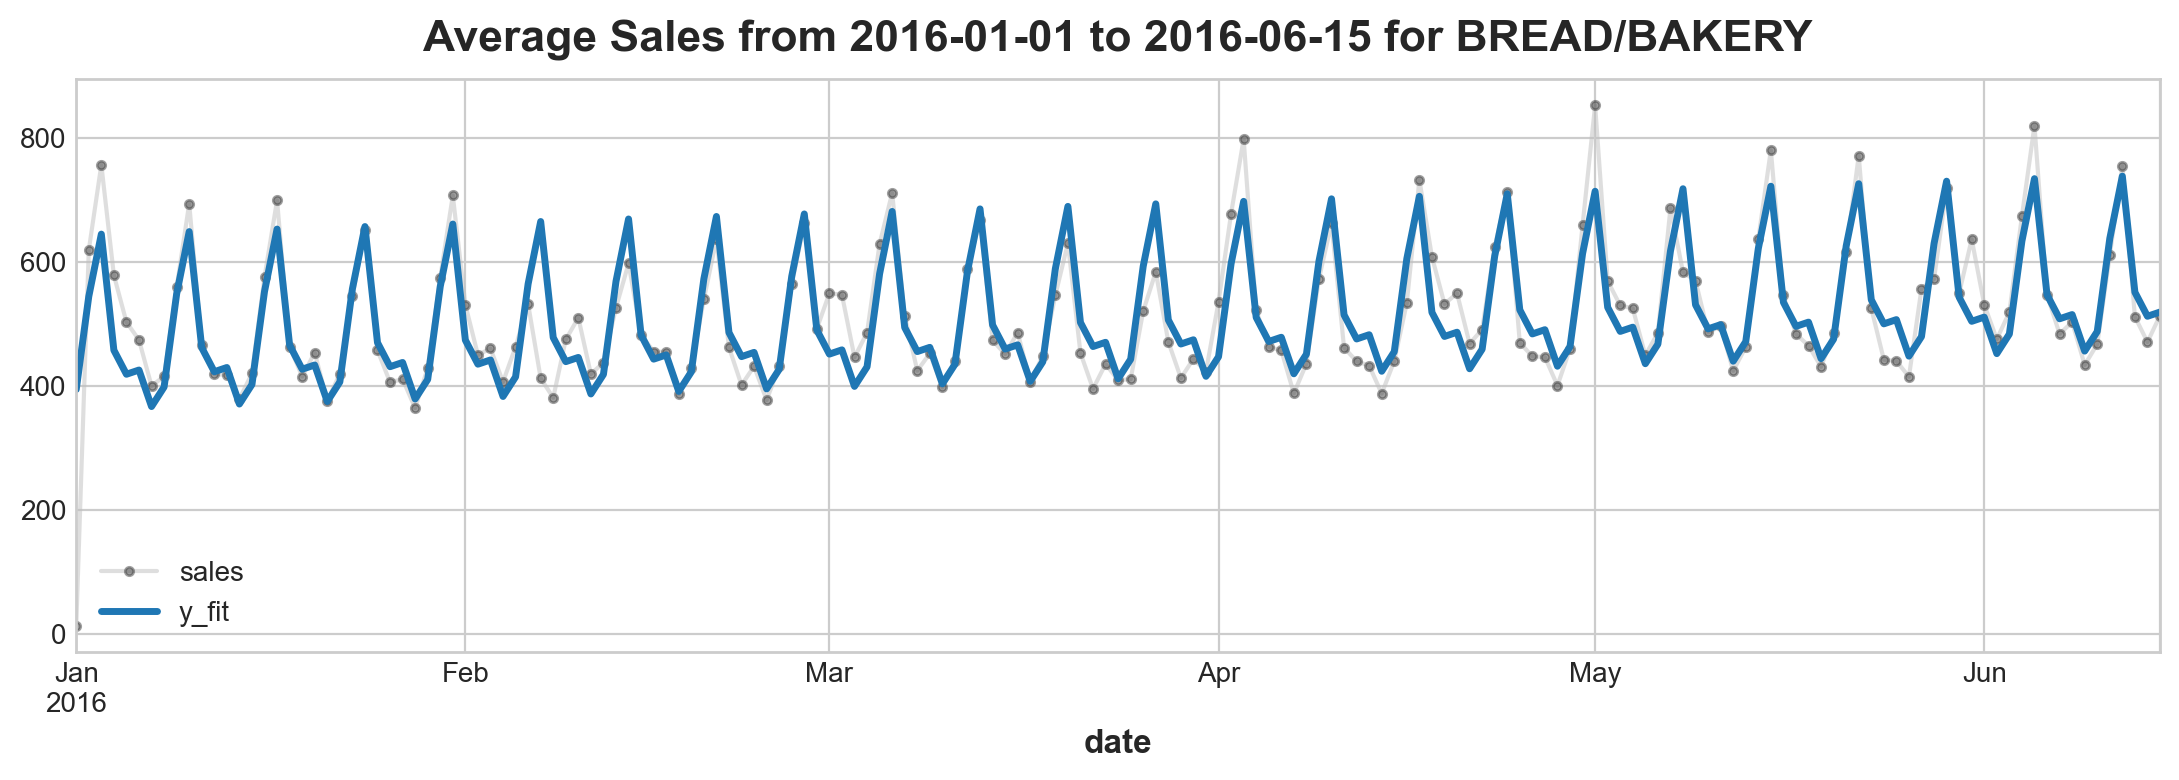

In [27]:
#Check fit with weekly seasonality
check(X_seasonal)

### Calendar Fourier

In [28]:
from statsmodels.tsa.deterministic import CalendarFourier
fourier = CalendarFourier(freq = 'A', order = 10)
dpf = DeterministicProcess(
                index = index_,
                constant = True,
                order = 1,
                seasonal = True,
                additional_terms = [fourier],
                drop = True

)
X_seas_fin = dpf.in_sample()
X_seas_fin


,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852,...,0.103102,0.994671,0.120208,0.992749,0.137279,0.990532,0.154309,0.988023,0.171293,0.985220
2013-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407,...,0.205104,0.978740,0.238673,0.971100,0.271958,0.962309,0.304921,0.952378,0.337523,0.941317
2013-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667,...,0.304921,0.952378,0.353676,0.935368,0.401488,0.915864,0.448229,0.893919,0.493776,0.869589
2013-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630,...,0.401488,0.915864,0.463550,0.886071,0.523416,0.852078,0.580800,0.814046,0.635432,0.772157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,1680.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.628763,-0.777597,...,-0.806480,-0.591261,0.998880,-0.047321,-0.746972,0.664855,0.162807,-0.986658,0.493776,0.869589
2017-08-12,1.0,1681.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.642055,-0.766659,...,-0.863142,-0.504961,0.985948,-0.167052,-0.648630,0.761104,0.008607,-0.999963,0.635432,0.772157
2017-08-13,1.0,1682.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.655156,-0.755493,...,-0.910605,-0.413279,0.958718,-0.284359,-0.538005,0.842942,-0.145799,-0.989314,0.758306,0.651899


RMSLE: 0.10720


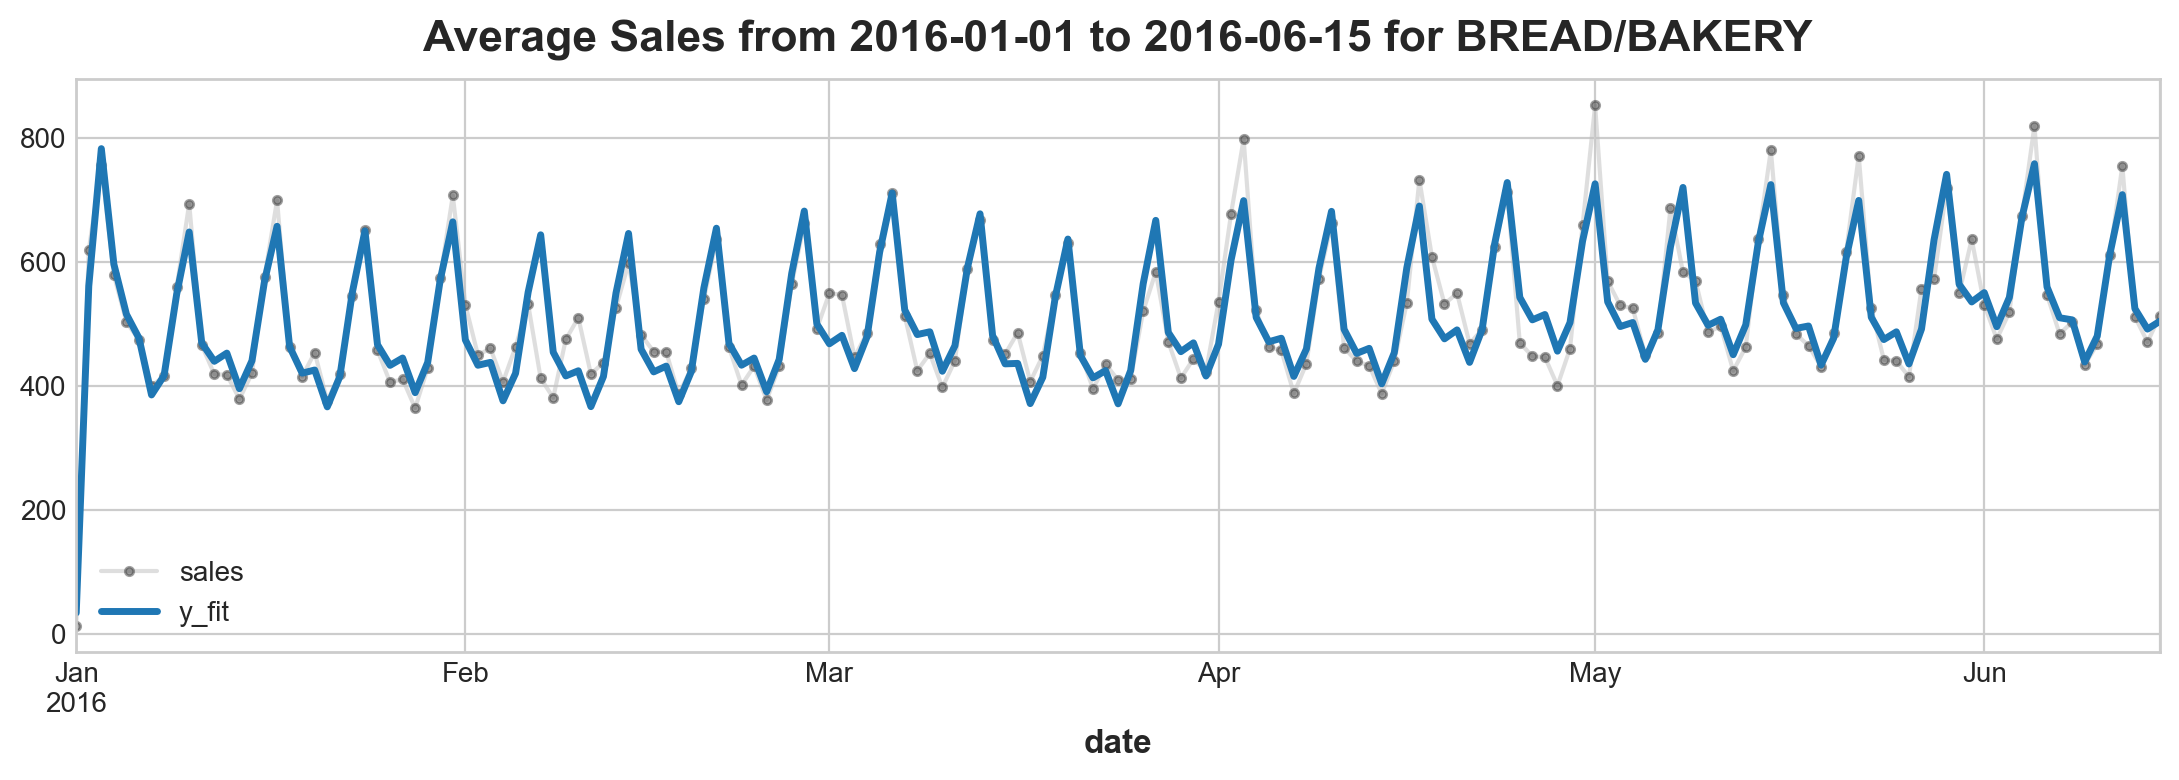

In [29]:
#Check Season Fin
check(X_seas_fin)

In [30]:
#Make predictions!

In [31]:
#y_fit
X_seas_fin
model_trend.fit(X_seas_fin, y_train)
y_seas_fit = pd.DataFrame(model_trend.predict(X_seas_fin), index = X_seas_fin.index, columns = y_train.columns)
y_seas_fit_stacked = y_seas_fit.stack([0, 1]).to_frame(name = 'sales')

In [32]:
#y_pred
X_seas_test = dpf.out_of_sample(test_len)
y_seas_pred = pd.DataFrame(model_trend.predict(X_seas_test), index = X_seas_test.index, columns = y_train.columns)
y_seas_pred_stacked = y_seas_pred.stack([0, 1]).to_frame(name = 'sales')

In [33]:
#Output
output3 = dtest.copy()
output3['sales_predictions'] = y_seas_pred_stacked['sales']
output3 = output3.set_index('id')['sales_predictions']
output3.to_csv('sales_predictions3.csv')

### Holidays

In [34]:
#get names
hol_names = (holidays.query("locale in 'National' and transferred == False")[['description']]
                     .assign(description = lambda x : x.description.cat.remove_unused_categories())
            
            
            )
duplicated_dates = hol_names.index.duplicated(keep = 'first')
hol_names = hol_names[~duplicated_dates]
#dummies
X_holidays = pd.get_dummies(hol_names['description'])
X_holidays.tail()

,Batalla de Pichincha,Black Friday,Carnaval,Cyber Monday,Dia de Difuntos,Dia de la Madre,Dia de la Madre-1,Dia del Trabajo,Inauguracion Mundial de futbol Brasil,Independencia de Cuenca,...,Terremoto Manabi+5,Terremoto Manabi+6,Terremoto Manabi+7,Terremoto Manabi+8,Terremoto Manabi+9,Traslado Batalla de Pichincha,Traslado Independencia de Guayaquil,Traslado Primer Grito de Independencia,Traslado Primer dia del ano,Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2017-12-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-12-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-12-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-12-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-12-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
#Join tables
X_hol_fin = X_seas_fin.join(X_holidays, how = 'left').fillna(0.0)


RMSLE: 0.06497


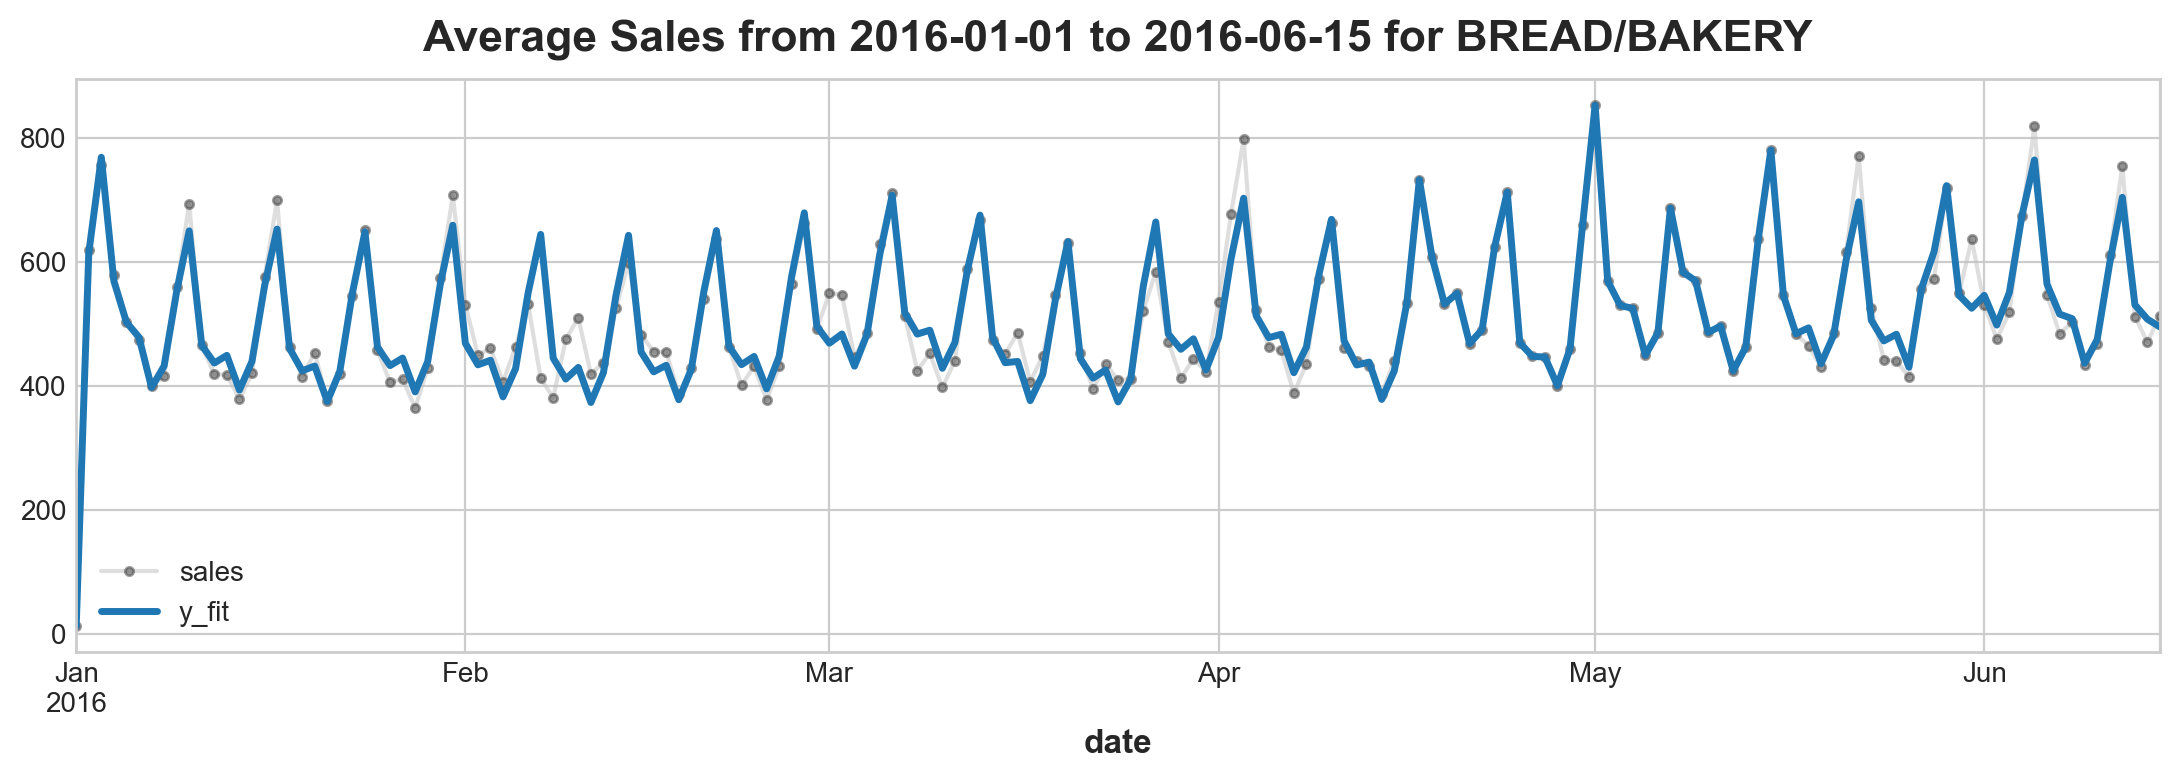

In [36]:
#Check
check(X_hol_fin)

In [37]:
#X_test
hol_names.iloc[-10:-8] #no holidays between 2017-08-16 and 2017-08-31

,description
date,
2017-08-11,Traslado Primer Grito de Independencia
2017-10-09,Independencia de Guayaquil


In [38]:
X_holidays_test = X_seas_test.join(X_holidays, how = 'left').fillna(0.0) #same method as with X_holidays
X_holidays_test

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,Terremoto Manabi+5,Terremoto Manabi+6,Terremoto Manabi+7,Terremoto Manabi+8,Terremoto Manabi+9,Traslado Batalla de Pichincha,Traslado Independencia de Guayaquil,Traslado Primer Grito de Independencia,Traslado Primer dia del ano,Viernes Santo
2017-08-16,1.0,1685.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.693281,-0.720667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-17,1.0,1686.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.705584,-0.708627,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-18,1.0,1687.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.717677,-0.696376,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-19,1.0,1688.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.729558,-0.683919,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-20,1.0,1689.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.741222,-0.671260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-21,1.0,1690.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.752667,-0.658402,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-22,1.0,1691.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.763889,-0.645348,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-23,1.0,1692.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.774884,-0.632103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-24,1.0,1693.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.785650,-0.618671,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-25,1.0,1694.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.796183,-0.605056,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
#Predictions
model_trend.fit(X_hol_fin, y_train)
y_holidays_pred = pd.DataFrame(model_trend.predict(X_holidays_test), index = X_holidays_test.index, columns = y_train.columns)
y_holidays_pred_stacked = y_holidays_pred.stack([0, 1]).to_frame(name = 'sales')
y_holidays_pred_stacked

sales
           family     store_nbr           
2017-08-16 AUTOMOTIVE 1           4.328043
                      10          2.673416
                      11          7.862622
                      12          6.609884
                      13          6.762398
...                                    ...
2017-08-31 SEAFOOD    54          1.401228
                      6          48.972191
                      7          62.916995
                      8          49.631081
                      9          15.193706

[28512 rows x 1 columns]

In [40]:
#Output
output4 = dtest.copy()
output4['sales_predictions'] = y_holidays_pred_stacked['sales']
output4 = output4.set_index('id')['sales_predictions']
output4.to_csv('sales_predictions4.csv')

# 4 Volcano

In [41]:
#Make Lags function
#Lag Function from DF
def my_lags(X, colname, lags):
    X_lags = X.copy()
    for i in range(lags):
        X_lags[f'lag_{i+1}'] = X_lags[colname].shift(i).fillna(0.0)
        
    X_lags = X_lags.drop('Volcano', axis = 1)
        
    return X_lags


#Lag Function from Series
def ser_lags(X, lags):
    X_lags = X.copy()
    X_lags = X_lags.to_frame(name = 'base')
    for i in range(lags):
        X_lags[f'lag_{i+1}'] = X_lags['base'].shift(i+1).fillna(0.0)
    
    X_lags = X_lags.drop('base', axis = 1)
    
    return X_lags

#Lag function from Github Repo
from learntools.time_series.utils import make_lags

In [42]:
#Get X_volcano - No Data Set!
'''
A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. 
People rallied in relief efforts donating water and other first need products, 
which greatly affected supermarket sales for several weeks after the earthquake.

'''

X_volcano = pd.DataFrame(X_hol_fin.index == '2016-04-16', index = index_, columns = ['Volcano'])
X_volcano['Volcano'] = X_volcano['Volcano'].apply(lambda x : 1 if x == True else 0)


X_volc2 = make_lags(X_volcano.squeeze(), lags = 22, name = 'volcano').fillna(0.0)
X_volc_fin = X_hol_fin.join(X_volc2)
X_volcano

,Volcano
date,
2013-01-01,0
2013-01-02,0
2013-01-03,0
2013-01-04,0
2013-01-05,0
...,...
2017-08-11,0
2017-08-12,0
2017-08-13,0


RMSLE: 0.06497


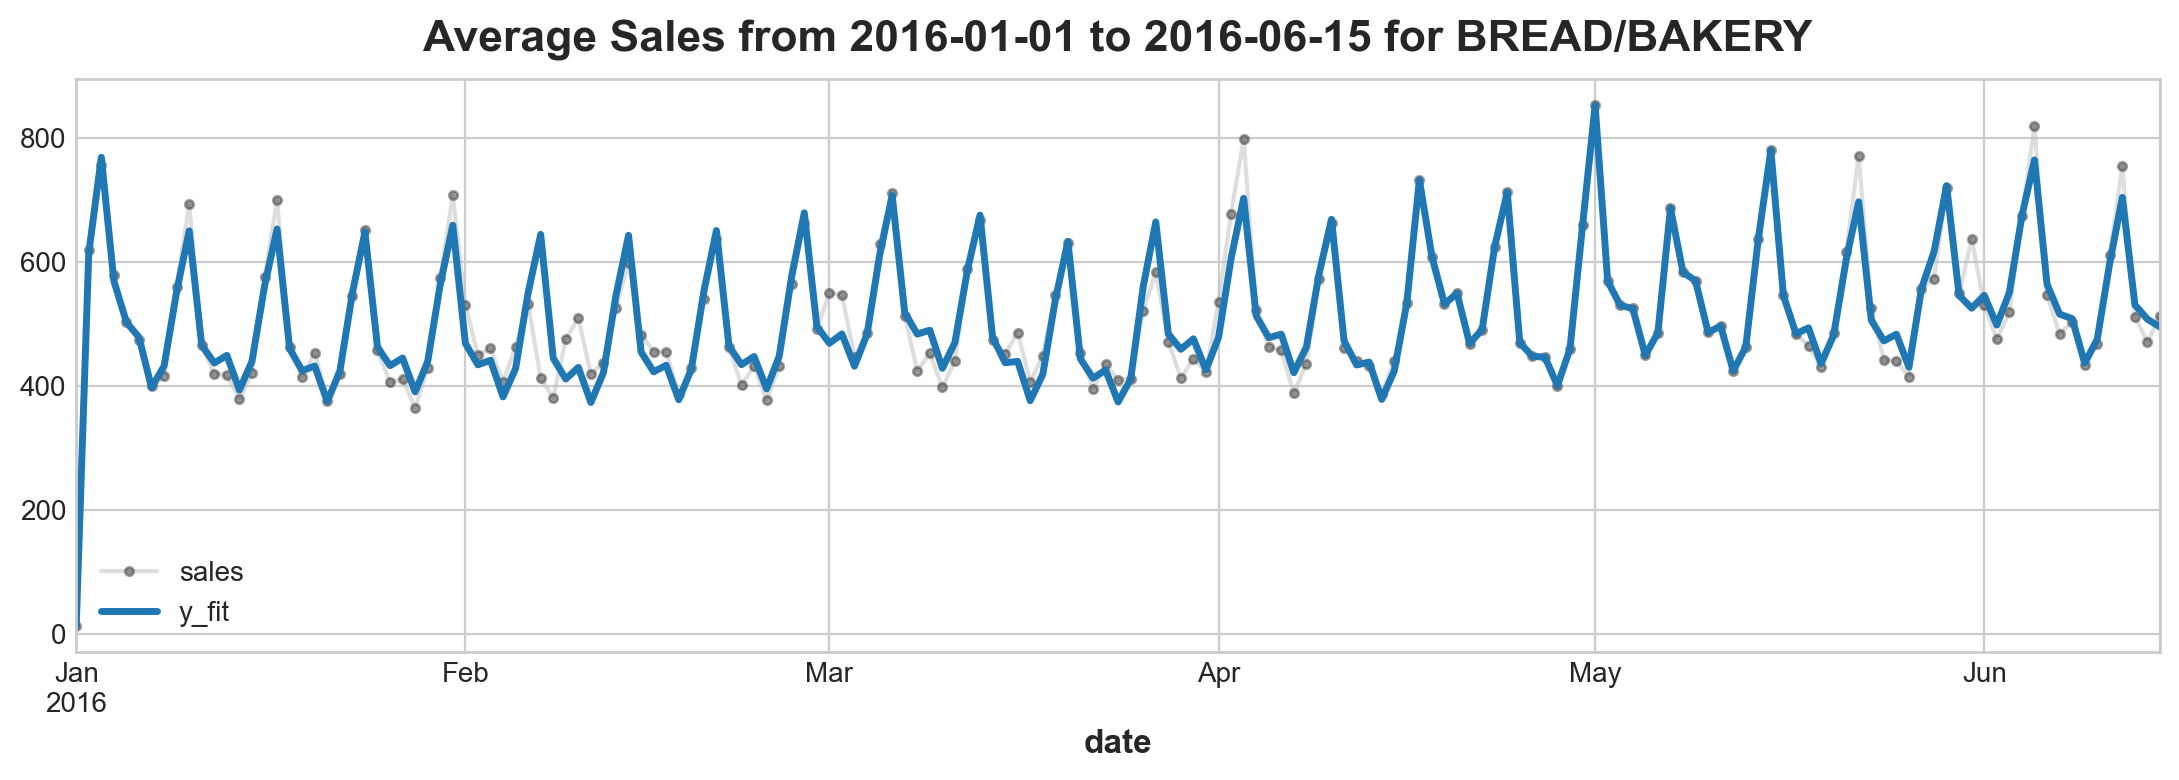

In [43]:
#Check
check(X_volc_fin)

In [44]:
X_volc2

,volcano_lag_1,volcano_lag_2,volcano_lag_3,volcano_lag_4,volcano_lag_5,volcano_lag_6,volcano_lag_7,volcano_lag_8,volcano_lag_9,volcano_lag_10,...,volcano_lag_13,volcano_lag_14,volcano_lag_15,volcano_lag_16,volcano_lag_17,volcano_lag_18,volcano_lag_19,volcano_lag_20,volcano_lag_21,volcano_lag_22
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
#X_test
X_volcano_test = X_holidays_test.join(X_volc2, how = 'left').fillna(0.0)
X_volcano_test

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,volcano_lag_13,volcano_lag_14,volcano_lag_15,volcano_lag_16,volcano_lag_17,volcano_lag_18,volcano_lag_19,volcano_lag_20,volcano_lag_21,volcano_lag_22
2017-08-16,1.0,1685.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.693281,-0.720667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-17,1.0,1686.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.705584,-0.708627,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-18,1.0,1687.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.717677,-0.696376,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-19,1.0,1688.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.729558,-0.683919,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-20,1.0,1689.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.741222,-0.671260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-21,1.0,1690.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.752667,-0.658402,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-22,1.0,1691.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.763889,-0.645348,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-23,1.0,1692.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.774884,-0.632103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-24,1.0,1693.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.785650,-0.618671,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-25,1.0,1694.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.796183,-0.605056,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
#Prediction
model_trend.fit(X_volc_fin, y_train)
X_volc_pred = pd.DataFrame(model_trend.predict(X_volcano_test), index = X_volcano_test.index, columns = y_train.columns)
X_volc_pred_stacked = X_volc_pred.stack([0, 1]).to_frame(name = 'sales')
#Output
output5 = dtest.copy()
output5['sales_predictions'] = X_volc_pred_stacked['sales']
output5 = output5.set_index('id')['sales_predictions']
output5.to_csv('sales_predictions5.csv')

# 5 MultiStep

### 5.0 Example for MultiSteps

In [47]:
from learntools.time_series.utils import load_multistep_data
datasets = load_multistep_data()

import ipywidgets as widgets
data_tabs = widgets.Tab([widgets.Output() for _ in enumerate(datasets)])
for i, df in enumerate(datasets):
    data_tabs.set_title(i, f'Dataset {i+1}')
    with data_tabs.children[i]:
        display(df)

display(data_tabs)

### 5.1 Get y and x

In [48]:
y_train.head()

family     AUTOMOTIVE                                                 ...  \
store_nbr           1   10    11   12   13   14   15   16    17   18  ...   
date                                                                  ...   
2013-01-01        0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...   
2013-01-02        2.0  3.0  12.0  4.0  7.0  8.0  4.0  5.0   8.0  1.0  ...   
2013-01-03        3.0  2.0   8.0  4.0  0.0  0.0  2.0  5.0   1.0  1.0  ...   
2013-01-04        3.0  2.0   5.0  5.0  3.0  5.0  2.0  2.0   1.0  1.0  ...   
2013-01-05        5.0  0.0   7.0  7.0  4.0  8.0  2.0  1.0  10.0  3.0  ...   

family        SEAFOOD                                                  \
store_nbr           5         50         51   52   53   54          6   
date                                                                    
2013-01-01   0.000000   0.000000   0.000000  0.0  0.0  0.0   0.000000   
2013-01-02  11.745000  42.265999  97.801003  0.0  0.0  3.0  54.538002   
2013-01-03  17.162001  26.146999  64.061996  0.0  0.0  2.0  43.271999   
2013-01-04  15.631001  25.663000  94.971001  0.0  0.0  2.0  45.702999   
2013-01-05  18.778999  32.327000  75.149002  0.0  0.0  1.0  60.305000   

family                                       
store_nbr           7          8          9  
date                                         
2013-01-01   0.000000   0.000000   0.000000  
2013-01-02  59.751999  72.283997  29.214001  
2013-01-03  41.428001  43.441002  25.000000  
2013-01-04  57.225998  49.507999  11.000000  
2013-01-05  31.939999  57.611000  28.361000  

[5 rows x 1782 columns]

In [49]:
#Get y_multistep
from learntools.time_series.utils import make_multistep_target
y_train_multi = make_multistep_target(y_train, 16).dropna()
y_train_multi.tail()

y_step_1                                                    ...  \
family     AUTOMOTIVE                                                    ...   
store_nbr           1   10    11   12    13    14   15    16    17   18  ...   
date                                                                     ...   
2017-07-27        5.0  0.0   5.0  7.0   4.0   6.0  5.0   4.0   6.0  0.0  ...   
2017-07-28        7.0  1.0   8.0  7.0  12.0   4.0  2.0   7.0  24.0  6.0  ...   
2017-07-29        4.0  0.0  10.0  3.0   4.0  12.0  2.0  10.0  10.0  5.0  ...   
2017-07-30        1.0  0.0   6.0  7.0   3.0   4.0  7.0   4.0   5.0  2.0  ...   
2017-07-31        8.0  2.0   4.0  6.0   6.0   0.0  2.0   7.0  11.0  4.0  ...   

           y_step_16                                                     \
family       SEAFOOD                                                      
store_nbr          5         50         51      52   53   54          6   
date                                                                      
2017-07-27     8.402  22.524000  74.933998  23.000  8.0  0.0  52.797001   
2017-07-28     7.320  15.801001  38.771999   5.000  6.0  1.0  35.029999   
2017-07-29    11.642  41.527000  39.965000  12.000  9.0  2.0  58.470001   
2017-07-30    11.694  12.242000  41.584000   6.595  9.0  0.0  37.879002   
2017-07-31     9.669  15.314000  52.875999   7.000  5.0  3.0  47.575001   

                                             
family                                       
store_nbr           7          8          9  
date                                         
2017-07-27  40.477001  48.734001  23.830999  
2017-07-28  42.545002  25.243999  16.859001  
2017-07-29  33.647999  35.257999  20.000000  
2017-07-30  47.977001  33.252998  17.000000  
2017-07-31  46.507000  23.330000  16.000000  

[5 rows x 28512 columns]

In [50]:
#Align X_train
X_volc_fin_multi = X_volc_fin.copy()
y_train_multi, X_volc_fin_multi = y_train_multi.align(X_volc_fin_multi, join = 'inner', axis = 0)
X_volc_fin_multi.tail()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,volcano_lag_13,volcano_lag_14,volcano_lag_15,volcano_lag_16,volcano_lag_17,volcano_lag_18,volcano_lag_19,volcano_lag_20,volcano_lag_21,volcano_lag_22
date,,,,,,,,,,,,,,,,,,,,,
2017-07-27,1.0,1665.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.409356,-0.912375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-07-28,1.0,1666.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.425000,-0.905193,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-07-29,1.0,1667.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.440519,-0.897743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-07-30,1.0,1668.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.455907,-0.890028,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-07-31,1.0,1669.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.471160,-0.882048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
#Check X_test
X_volcano_test.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,volcano_lag_13,volcano_lag_14,volcano_lag_15,volcano_lag_16,volcano_lag_17,volcano_lag_18,volcano_lag_19,volcano_lag_20,volcano_lag_21,volcano_lag_22
2017-08-16,1.0,1685.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.693281,-0.720667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-17,1.0,1686.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.705584,-0.708627,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-18,1.0,1687.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.717677,-0.696376,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-19,1.0,1688.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.729558,-0.683919,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-20,1.0,1689.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.741222,-0.671260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 5.2 Check MultiStep

In [52]:
#Functions
def check_multistep (
            data,    
            y = y_train,
            START = START, 
            END = END,
            FAMILY = FAMILY,
            STORE = STORE,
            EVERY = 16
):
       
    fit = (data
           .stack(['family', 'store_nbr'])
           .query('family == @FAMILY and store_nbr == @STORE')
           .reset_index(['family', 'store_nbr'], drop=True)
           .loc[START:END]
          )

    y = (y
         .stack(['family', 'store_nbr'])
         .to_frame()
         .query('family == @FAMILY and store_nbr == @STORE')
         .reset_index(['family', 'store_nbr'],drop=True)
         .rename(columns={0:'ground_truth'})
         .loc[START:END]
         .squeeze()
        )

    fig, ax = plt.subplots(1, 1, figsize=(11, 4))
    ax = y.plot(**plot_params, ax=ax, alpha=0.5)
    ax = plot_multistep(fit, ax=ax, every=EVERY)
    ax.set_title (f'16-days forecasts against ground-truth for {FAMILY} from {START} till {END}')
    
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

In [53]:
from learntools.time_series.utils import plot_multistep

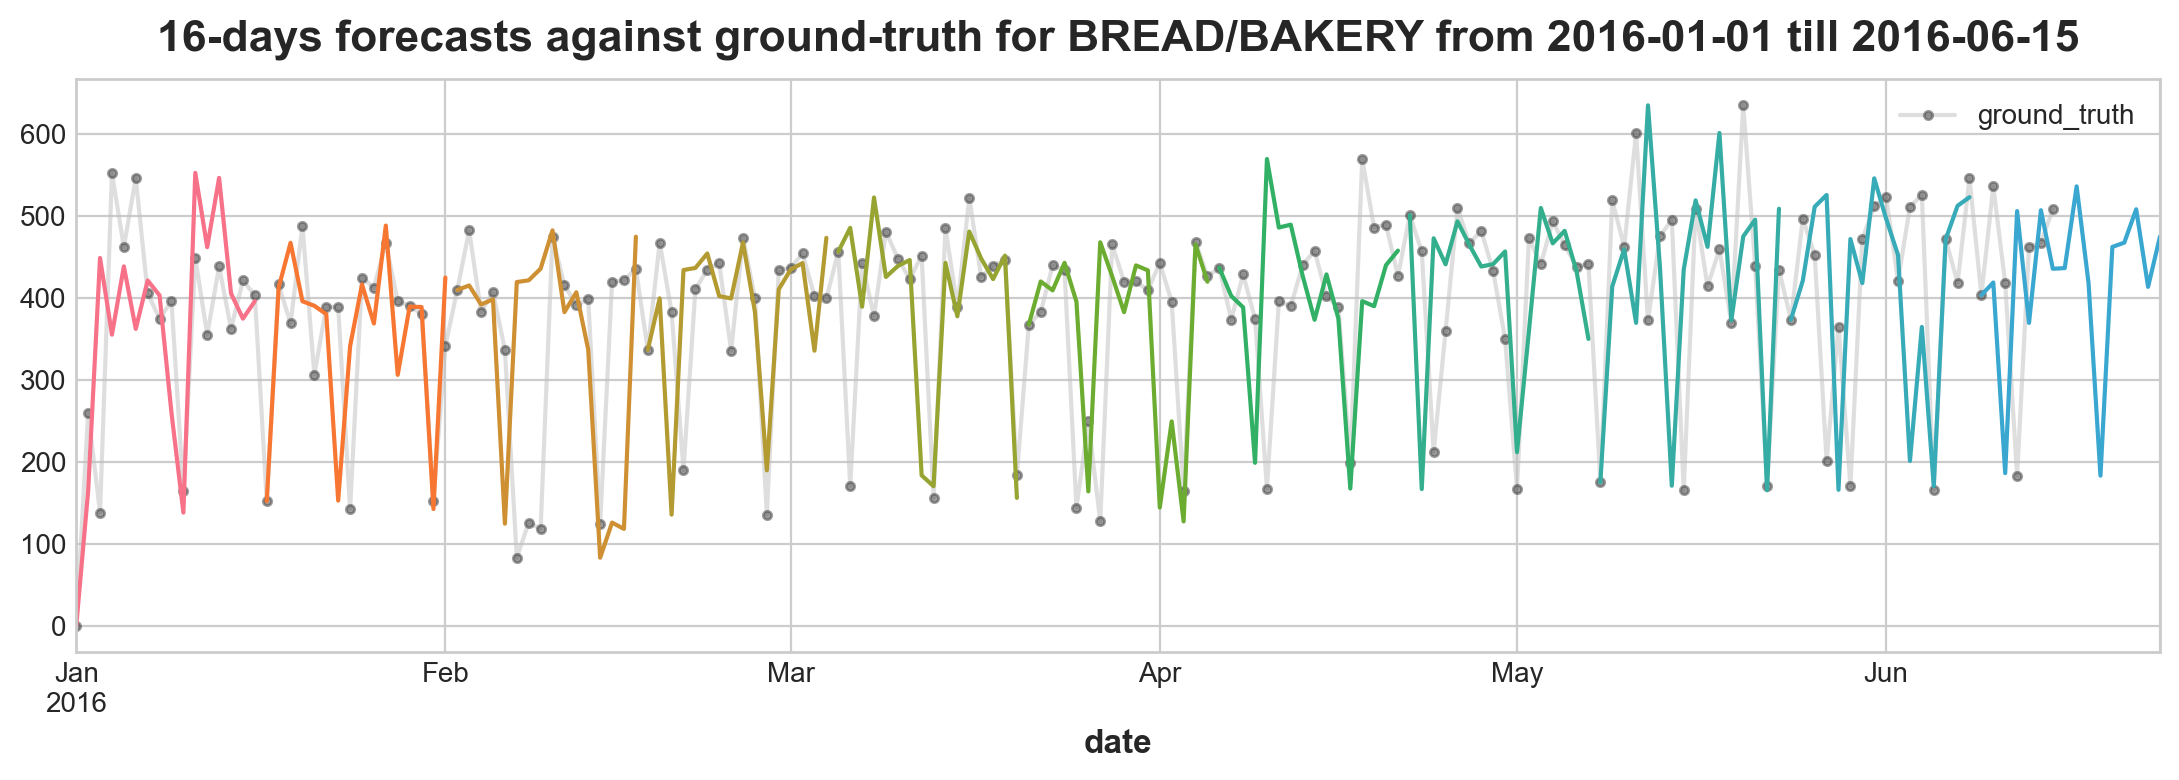

In [54]:
#Check for fit for 1 family and 1 store in first half of 2016
check_multistep(y_train_multi)

### 5.3 Fit and Predict

In [55]:
#Fit
model_trend.fit(X_volc_fin_multi, y_train_multi)
y_multi_test = pd.DataFrame(model_trend.predict(X_volcano_test), index = X_volcano_test.index, columns = y_train_multi.columns).clip(0.0)
y_multi_test

y_step_1                                                    \
family     AUTOMOTIVE                                                     
store_nbr           1        10        11        12        13        14   
2017-08-16   4.307486  2.814652  7.938923  6.576714  6.951033  3.633649   
2017-08-17   4.491390  2.714614  7.614914  6.368583  6.156324  2.990861   
2017-08-18   4.832344  2.426651  7.086259  5.725039  5.672474  2.937637   
2017-08-19   4.601475  3.092145  8.014429  6.400813  6.254298  3.494161   
2017-08-20   4.500936  3.011703  8.441713  6.836244  6.791114  3.639586   
2017-08-21   4.003766  3.194531  8.508453  6.983261  6.807656  3.514492   
2017-08-22   4.114923  3.713685  8.294354  6.983374  7.206243  3.985178   
2017-08-23   4.177521  3.124806  7.944544  6.657627  7.199084  3.620173   
2017-08-24   4.404035  3.024283  7.641479  6.415905  6.406106  3.046545   
2017-08-25   4.788209  2.732114  7.125432  5.739205  5.919891  3.060812   
2017-08-26   4.600196  3.389385  8.057241  6.382705  6.494593  3.681875   
2017-08-27   4.541190  3.296505  8.478822  6.787136  7.018990  3.887688   
2017-08-28   4.083307  3.462588  8.530422  6.904765  7.017438  3.817742   
2017-08-29   4.230640  3.960709  8.291928  6.877386  7.392054  4.337395   
2017-08-30   4.325513  3.346642  7.908921  6.526277  7.355044  4.014395   
2017-08-31   4.579709  3.217029  7.564574  6.261506  6.526541  3.475212   

                                                     ...  y_step_16  \
family                                               ...    SEAFOOD   
store_nbr         15        16         17        18  ...          5   
2017-08-16  3.437779  3.983759  10.302870  3.079490  ...  11.163739   
2017-08-17  2.727475  3.915097   9.573718  2.166810  ...  10.342943   
2017-08-18  2.581496  3.264147   8.712042  1.773185  ...  10.142793   
2017-08-19  2.880504  3.401025   9.423410  2.056930  ...  10.539050   
2017-08-20  2.922151  3.797014   9.843085  2.443605  ...  10.515882   
2017-08-21  3.049480  4.267158   9.642576  2.402526  ...  10.553238   
2017-08-22  3.138494  4.260652   9.513835  2.606544  ...   9.404437   
2017-08-23  3.318380  4.520936   9.535272  2.890943  ...  10.351312   
2017-08-24  2.641833  4.441506   8.831714  2.012134  ...   9.639822   
2017-08-25  2.528880  3.768791   8.007530  1.649701  ...   9.548915   
2017-08-26  2.859327  3.873768   8.766819  1.961536  ...  10.052003   
2017-08-27  2.930038  4.228779   9.243179  2.372898  ...  10.131122   
2017-08-28  3.083354  4.650101   9.106314  2.352936  ...  10.264358   
2017-08-29  3.194693  4.588298   9.046275  2.574462  ...   9.203480   
2017-08-30  3.392781  4.788286   9.139534  2.872854  ...  10.229102   
2017-08-31  2.729999  4.645111   8.508993  2.004735  ...   9.586322   

                                                                           \
family                                                                      
store_nbr          50         51        52        53        54          6   
2017-08-16  18.812415  52.208279  1.912103  6.816670  1.446644  48.838099   
2017-08-17  16.830039  51.326450  2.031269  7.126889  1.409737  44.972941   
2017-08-18  17.398315  54.341969  2.277568  7.765333  1.508137  46.108447   
2017-08-19  18.739373  61.009851  2.159673  7.913639  1.343957  52.683739   
2017-08-20  18.929652  60.859061  1.989261  8.283849  1.626467  54.465832   
2017-08-21  20.531606  62.742256  2.185907  7.719900  1.526619  54.444599   
2017-08-22  20.006811  57.530785  1.924935  7.068572  1.706031  54.912383   
2017-08-23  19.117144  52.357537  1.993954  6.478722  1.194396  49.706836   
2017-08-24  17.350604  51.699742  2.148699  6.828320  1.169001  45.863643   
2017-08-25  18.127035  54.934444  2.424309  7.512627  1.282327  47.031986   
2017-08-26  19.664670  61.808841  2.329059  7.712127  1.136485  53.648533   
2017-08-27  20.036280  61.844356  2.174402  8.137587  1.440691  55.477527   
2017-08-28  21.800942  63.886587  2.379874  7.631579  1.365785  55.505821   
2017-

### 5.4 Get final y test with Fetch Forecast

In [56]:
#Function
def fetch_forecast (
        data,
        START = '2017-08-16',
        END = '2017-08-31'):
    
    X = data.loc[START]
    DATES = pd.period_range (START, END)                                # this is needed for iteration through a list of all 
    index_to_rename = X.index.get_level_values(0).unique()[:len(DATES)] # dates in the horizon (when calculating an average)
    rename_dict = dict(zip(index_to_rename, DATES))

    forecast = X.rename(rename_dict, level = 0).to_frame(name='sales_predictions')
    forecast.index = forecast.index.set_names('date',level = 0)
    
    return forecast

In [57]:
#Calling the function
y_mul_fin = fetch_forecast(y_multi_test)
y_mul_fin

sales_predictions
date       family     store_nbr                   
2017-08-16 AUTOMOTIVE 1                   4.307486
                      10                  2.814652
                      11                  7.938923
                      12                  6.576714
                      13                  6.951033
...                                            ...
2017-08-31 SEAFOOD    54                  1.446644
                      6                  48.838099
                      7                  63.350269
                      8                  49.993739
                      9                  15.298112

[28512 rows x 1 columns]

### 5.5 Output

In [58]:
def make_output(y_test, dtest = dtest): #y_test input - DataFrame with 1 column
    output = y_test.copy()
    output['id'] = dtest['id']
    output = output.set_index('id').squeeze()
    
    return output

In [59]:
#output
output6 = make_output(y_mul_fin)
output6.to_csv('sales_predictions6.csv')

# 6 Boosted Hybrid

### 6.1 Get X2

In [60]:
#Get X2
from sklearn.preprocessing import LabelEncoder
le_family = LabelEncoder()

X2 = dtrain.copy()
X2['family_fact'] = le_family.fit_transform(X2.index.get_level_values('family'))
X2['store_fact'] = X2.index.get_level_values('store_nbr').astype(int)
X2 = X2.drop('sales', axis = 1)

#Get X2_test
X2_test = dtest.copy()
X2_test['family_fact'] = le_family.fit_transform(X2_test.index.get_level_values(level = 1))
X2_test['store_fact'] = X2_test.index.get_level_values('store_nbr').astype(int)
X2_test = X2_test.drop('id', axis = 1)


In [61]:
'''#Linear Model
model_trend.fit(X_volc_fin, y_train)
y_lin_fit = pd.DataFrame(model_trend.predict(X_volc_fin), index = X_volc_fin.index, columns = y_train.columns)
y_des = y_train - y_lin_fit
y_des_stacked = y_des.stack(['family', 'store_nbr'])

y_lin_pred = pd.DataFrame(model_trend.predict(X_volcano_test), index = X_volcano_test.index, columns = y_train.columns)'''

"#Linear Model\nmodel_trend.fit(X_volc_fin, y_train)\ny_lin_fit = pd.DataFrame(model_trend.predict(X_volc_fin), index = X_volc_fin.index, columns = y_train.columns)\ny_des = y_train - y_lin_fit\ny_des_stacked = y_des.stack(['family', 'store_nbr'])\n\ny_lin_pred = pd.DataFrame(model_trend.predict(X_volcano_test), index = X_volcano_test.index, columns = y_train.columns)"

In [62]:
'''#Boosting Model
from xgboost import XGBRegressor
model_boost = XGBRegressor()
model_boost.fit(X2, y_des_stacked)
y_boost_pred = pd.Series(model_boost.predict(X2_test), index = X2_test.index)
y_boost_pred_unstacked = y_boost_pred.unstack(['family', 'store_nbr'])
y_pred = y_lin_pred + y_boost_pred_unstacked
y_pred = y_pred.clip(0.0)
y_pred'''

"#Boosting Model\nfrom xgboost import XGBRegressor\nmodel_boost = XGBRegressor()\nmodel_boost.fit(X2, y_des_stacked)\ny_boost_pred = pd.Series(model_boost.predict(X2_test), index = X2_test.index)\ny_boost_pred_unstacked = y_boost_pred.unstack(['family', 'store_nbr'])\ny_pred = y_lin_pred + y_boost_pred_unstacked\ny_pred = y_pred.clip(0.0)\ny_pred"

### 6.2 The Class

In [63]:
class BoostedHybrid:
    def __init__(self, model1, model2):
        self.model1 = model1
        self.model2 = model2
        self.y_columns = None
        
    def fit(self, X1, X2, y_train):    #X1, y_train - wide format, X2 - long format
        self.model1.fit(X1, y_train) 
        y_fit = pd.DataFrame(self.model1.predict(X1), index = X1.index, columns = y_train.columns)
        y_des = y_train - y_fit
        
        y_des_stacked = y_des.stack(['family', 'store_nbr'])
        self.model2.fit(X2, y_des_stacked) 
        
        self.y_columns = y_train.columns
        
    def predict(self, X1_test, X2_test): #X1_test - wide format, X2_test - long format
        y_lin_pred = pd.DataFrame(self.model1.predict(X1_test), index = X1_test.index, columns = self.y_columns) #wide format
        
        y_boost_pred = pd.Series(self.model2.predict(X2_test), index = X2_test.index) #long format
        y_boost_pred_unstacked = y_boost_pred.unstack(['family', 'store_nbr'])
        
        y_pred = y_lin_pred + y_boost_pred_unstacked
        y_pred = y_pred.clip(0.0)
        y_pred = y_pred.stack([0, 1])
        
        return y_pred
             

In [64]:
#Calling the Class
from xgboost import XGBRegressor
model_hyb = BoostedHybrid(LinearRegression(fit_intercept = False), XGBRegressor())
model_hyb.fit(X_volc_fin, X2, y_train)
y_hyb_pred = model_hyb.predict(X_volcano_test, X2_test)
y_hyb_pred = y_hyb_pred.to_frame().rename(columns = {0:'sales predictions'})
y_hyb_pred

sales predictions
           family     store_nbr                   
2017-08-16 AUTOMOTIVE 1                   4.666421
                      10                  4.193759
                      11                  8.824383
                      12                  7.134791
                      13                  8.747478
...                                            ...
2017-08-31 SEAFOOD    54                  5.479369
                      6                  36.500529
                      7                  51.122941
                      8                  36.989812
                      9                  12.136071

[28512 rows x 1 columns]

### 6.3 Output

In [65]:
output7 = make_output(y_hyb_pred)
output7.to_csv('sales_predictions7.csv')

# 7 Stacked Hybrid

In [66]:
#Experimenting
model_trend.fit(X_volc_fin, y_train)
y_lin_fit = pd.DataFrame(model_trend.predict(X_volc_fin), index = X_volc_fin.index, columns = y_train.columns) #wide format
y_lin_fit_long = y_lin_fit.stack(['family', 'store_nbr'])
X2_y = X2.copy()
X2_y['target'] = y_lin_fit_long

y_train_long = y_train.stack(['family', 'store_nbr'])
y_train_long

date        family      store_nbr
2013-01-01  AUTOMOTIVE  1             0.000000
                        10            0.000000
                        11            0.000000
                        12            0.000000
                        13            0.000000
                                       ...    
2017-08-15  SEAFOOD     54            3.000000
                        6            47.575001
                        7            46.507000
                        8            23.330000
                        9            16.000000
Length: 3000888, dtype: float32

In [67]:
X2

onpromotion  family_fact  store_fact
date       family     store_nbr                                      
2013-01-01 AUTOMOTIVE 1                    0            0           1
                      10                   0            0          10
                      11                   0            0          11
                      12                   0            0          12
                      13                   0            0          13
...                                      ...          ...         ...
2017-08-15 SEAFOOD    54                   0           32          54
                      6                    0           32           6
                      7                    0           32           7
                      8                    0           32           8
                      9                    0           32           9

[3000888 rows x 3 columns]

In [68]:
#Creating the Class
class StackedHybrid:
    def __init__(self, model1, model2):
        self.model1 = model1
        self.model2 = model2
        
    def fit(self, X1, X2, y_train): #X1, y_train - wide format, X2 - long format
        self.model1.fit(X1, y_train)
        y_lin_fit = pd.DataFrame(self.model1.predict(X1), index = X1.index, columns = y_train.columns) #wide format
        y_lin_fit_long = y_lin_fit.stack(['family', 'store_nbr'])
        
        X2 = X2.copy()
        X2['target'] = y_lin_fit_long
        y_train_long = y_train.stack(['family', 'store_nbr']) #XGBoost cannot handle wide format!
                                         
        self.model2.fit(X2, y_train_long)
        
        self.y_columns = y_train.columns
        
    def predict(self, X1_test, X2_test):
        y_lin_pred = pd.DataFrame(self.model1.predict(X1_test), index = X1_test.index, columns = self.y_columns) #wide format
        y_lin_pred_long = y_lin_pred.stack(['family', 'store_nbr']) #long format
        
        X2_test = X2_test.copy()
        X2_test['target'] = y_lin_pred_long
        
        y_pred = pd.Series(self.model2.predict(X2_test), index = X2_test.index)
        y_pred = y_pred.clip(0.0)
        
        return y_pred
        

In [69]:
#Calling the class
model_stacked = StackedHybrid(LinearRegression(fit_intercept = False), XGBRegressor())
model_stacked.fit(X_volc_fin, X2, y_train)

In [70]:
y_stacked_pred = model_stacked.predict(X_volcano_test, X2_test)
y_stacked_pred = y_stacked_pred.to_frame().rename(columns = {0:'sales predictions'})
y_stacked_pred

sales predictions
date       family     store_nbr                   
2017-08-16 AUTOMOTIVE 1                   4.681885
                      10                  3.044295
                      11                  5.553308
                      12                  5.553308
                      13                  5.738374
...                                            ...
2017-08-31 SEAFOOD    54                  6.503822
                      6                  51.878471
                      7                  58.118301
                      8                  51.878471
                      9                  14.764157

[28512 rows x 1 columns]

In [71]:
#Output
output8 = make_output(y_stacked_pred)
output8.to_csv('sales_predictions8.csv')

# 8 MultiBoostedHybrid

### 8.1 DataSets

In [72]:
#y_train_multi, X_volc_fin_multi, X_volcano_test, X2, X2_test
X2_m = X2.copy()
X2_m = X2_m.unstack(['family', 'store_nbr'])
X_volc_fin_multi, X2_m = X_volc_fin_multi.align(X2_m, join = 'inner', axis = 0)
X2_m = X2_m.stack(['family', 'store_nbr'])
X2_test = X2_test[['family_fact', 'onpromotion', 'store_fact']]
X2_test

family_fact  onpromotion  store_fact
date       family     store_nbr                                      
2017-08-16 AUTOMOTIVE 1                    0            0           1
                      10                   0            0          10
                      11                   0            0          11
                      12                   0            0          12
                      13                   0            0          13
...                                      ...          ...         ...
2017-08-31 SEAFOOD    54                  32            0          54
                      6                   32            1           6
                      7                   32            1           7
                      8                   32            1           8
                      9                   32            0           9

[28512 rows x 3 columns]

### 8.2 Class

In [73]:
#Class
class MultiBoostedHybrid:
    def __init__(self, model1, model2):
        self.model1 = model1
        self.model2 = model2
        self.y_columns = None
        
    def fit(self, X1, X2, y_train_multi):
        #fit linear model and get y_lin_fit
        self.model1.fit(X1, y_train_multi)
        y_lin_multi_fit = pd.DataFrame(self.model1.predict(X1), index = X1.index, columns = y_train_multi.columns)
        
        #compute y residuals and stack it for Xgboosting
        y_resid = y_train_multi - y_lin_multi_fit
        y_resid_stacked = y_resid.stack(['family', 'store_nbr']) #long format but 16 columns
        
        #fit Xgboost model
        self.model2.fit(X2, y_resid_stacked)
        
        #store y_columns
        self.y_columns = y_train_multi.columns
        self.y_resid_columns = y_resid_stacked.columns
        
    def predict(self, X1_test, X2_test):
        #get prediction of the linear model
        y_lin_pred = pd.DataFrame(self.model1.predict(X1_test), index = X1_test.index, columns = self.y_columns)
        y_lin_pred_stacked = y_lin_pred.stack(['family', 'store_nbr'])
        
        #get prediction of the Xgboost model
        y_boost_pred = pd.DataFrame(self.model2.predict(X2_test), index = X2_test.index, columns = self.y_resid_columns)
        
        #add them together
        y_pred = y_lin_pred_stacked + y_boost_pred
        y_pred = y_pred.clip(0.0)
        
        return y_pred
        
    

In [74]:
#Calling the Class
from sklearn.multioutput import RegressorChain
model_MBH = MultiBoostedHybrid(LinearRegression(fit_intercept = False),
                               RegressorChain(XGBRegressor(
                                                   n_estimators = 10, max_depth = 3, learning_rate = 0.1, n_jobs = 8)))
model_MBH.fit(X_volc_fin_multi, X2_m, y_train_multi)

In [75]:
#Predict
y_MBH_fore = model_MBH.predict(X_volcano_test, X2_test)
y_MBH_fore.head()

y_step_1  y_step_10  y_step_11  y_step_12  \
           family     store_nbr                                              
2017-08-16 AUTOMOTIVE 1          1.142988   3.596862   3.594443   4.077920   
                      10         0.000000   1.499713   2.371308   3.016348   
                      11         4.774425   5.746140   7.028983   8.414944   
                      12         3.412216   4.562941   5.278491   6.502965   
                      13         3.786536   4.584693   5.664418   6.508485   

                                 y_step_13  y_step_14  y_step_15  y_step_16  \
           family     store_nbr                                               
2017-08-16 AUTOMOTIVE 1           3.609280   5.757667   1.538649   5.781841   
                      10          3.254079   5.376942   0.330434   4.352445   
                      11          8.245540   9.928753   5.021543   8.515312   
                      12          6.660561   8.123307   3.683051   7.342308   
                      13          6.724667   8.845241   4.197186   7.543187   

                                 y_step_2  y_step_3  y_step_4  y_step_5  \
           family     store_nbr                                           
2017-08-16 AUTOMOTIVE 1          3.044266  3.413907  3.431447  1.792629   
                      10         1.209004  0.977726  2.292572  0.488869   
                      11         6.146397  5.747367  7.088620  5.724641   
                      12         4.498631  4.359478  5.435909  4.286381   
                      13         4.487012  4.327010  5.318797  4.390945   

                                 y_step_6  y_step_7  y_step_8  y_step_9  
           family     store_nbr                                          
2017-08-16 AUTOMOTIVE 1          2.831374  3.314820  4.181334  0.495189  
                      10         2.101600  2.752155  3.135841  0.000000  
                      11         7.460838  7.759516  7.965012  3.946076  
                      12         6.054935  6.107057  6.811776  2.834658  
                      13         5.752075  6.335569  7.363875  2.780835

### 8.3 Output

In [76]:
y_MBH_fore = y_MBH_fore[['y_step_1', 'y_step_2', 'y_step_3', 'y_step_4', 'y_step_5', 'y_step_6', 'y_step_7', 'y_step_8', 
                         'y_step_9', 'y_step_10', 'y_step_11', 'y_step_12', 'y_step_13', 'y_step_14', 'y_step_15', 'y_step_16']]
y_MBH_fore

y_step_1   y_step_2   y_step_3   y_step_4  \
           family     store_nbr                                               
2017-08-16 AUTOMOTIVE 1           1.142988   3.044266   3.413907   3.431447   
                      10          0.000000   1.209004   0.977726   2.292572   
                      11          4.774425   6.146397   5.747367   7.088620   
                      12          3.412216   4.498631   4.359478   5.435909   
                      13          3.786536   4.487012   4.327010   5.318797   
...                                    ...        ...        ...        ...   
2017-08-31 SEAFOOD    54          0.000000   0.000000   0.000000   0.418398   
                      6          42.408286  42.999142  44.832448  51.112804   
                      7          56.311735  62.951785  65.407585  64.332026   
                      8          43.051862  47.343354  52.553921  58.022582   
                      9           2.572318  11.115827  13.004141  15.645953   

                                  y_step_5   y_step_6   y_step_7   y_step_8  \
           family     store_nbr                                               
2017-08-16 AUTOMOTIVE 1           1.792629   2.831374   3.314820   4.181334   
                      10          0.488869   2.101600   2.752155   3.135841   
                      11          5.724641   7.460838   7.759516   7.965012   
                      12          4.286381   6.054935   6.107057   6.811776   
                      13          4.390945   5.752075   6.335569   7.363875   
...                                    ...        ...        ...        ...   
2017-08-31 SEAFOOD    54          0.000000   0.359471   0.860612   1.306205   
                      6          51.278679  52.644980  53.735295  50.329012   
                      7          61.352918  61.948528  63.717438  64.046588   
                      8          58.626363  61.125033  57.327861  50.938933   
                      9          15.780634  16.053471  16.449112  16.082915   

                                  y_step_9  y_step_10  y_step_11  y_step_12  \
           family     store_nbr                                               
2017-08-16 AUTOMOTIVE 1           0.495189   3.596862   3.594443   4.077920   
                      10          0.000000   1.499713   2.371308   3.016348   
                      11          3.946076   5.746140   7.028983   8.414944   
                      12          2.834658   4.562941   5.278491   6.502965   
                      13          2.780835   4.584693   5.664418   6.508485   
...                                    ...        ...        ...        ...   
2017-08-31 SEAFOOD    54          0.000000   0.007468   0.092777   1.019294   
                      6          42.140019  54.917400  52.305671  54.813726   
                      7          62.071663  74.746896  64.371978  63.555260   
                      8          46.828163  62.374163  58.468137  61.366635   
                      9           9.872672  14.376356  16.347904  18.604549   

                                 y_step_13  y_step_14  y_step_15  y_step_16  
           family     store_nbr                                              
2017-08-16 AUTOMOTIVE 1           3.609280   5.757667   1.538649   5.781841  
                      10          3.254079   5.376942   0.330434   4.352445  
                      11          8.245540   9.928753   5.021543   8.515312  
                      12          6.660561   8.123307   3.683051   7.342308  
                      13          6.724667   8.845241   4.197186   7.543187  
...                                    ...        ...        ...        ...  
2017-08-31 SEAFOOD    54          0.983026   2.923773   0.000000   2.173899  
                      6          54.442837  56.742444  48.204341  48.130745  
                      7          62.542229  65.383711  60.809305  66.661182  
                      8          61.957448  59.745652  48.556847  51.848676  
              

In [77]:
y_MBH_fore_wide = y_MBH_fore.unstack(['family', 'store_nbr'])
forecast = fetch_forecast(y_MBH_fore_wide)
output9 = make_output(forecast)
output9.to_csv('sales_predictions9.csv')
forecast

sales_predictions
date       family     store_nbr                   
2017-08-16 AUTOMOTIVE 1                   1.142988
                      10                  0.000000
                      11                  4.774425
                      12                  3.412216
                      13                  3.786536
...                                            ...
2017-08-31 SEAFOOD    54                  2.520138
                      6                  49.911593
                      7                  64.423763
                      8                  51.067233
                      9                  16.371606

[28512 rows x 1 columns]

# 9 Boosted, Multistep and Cycles

In [78]:
y_true

date
2016-01-01      0.000000
2016-01-02    259.811005
2016-01-03    138.274994
2016-01-04    552.171997
2016-01-05    461.738007
                 ...    
2016-06-11    417.851990
2016-06-12    183.319000
2016-06-13    462.028992
2016-06-14    467.203003
2016-06-15    507.850006
Freq: D, Name: ground_truth, Length: 167, dtype: float32

### 9.1 Examine Partial Autocorrelation and Lags

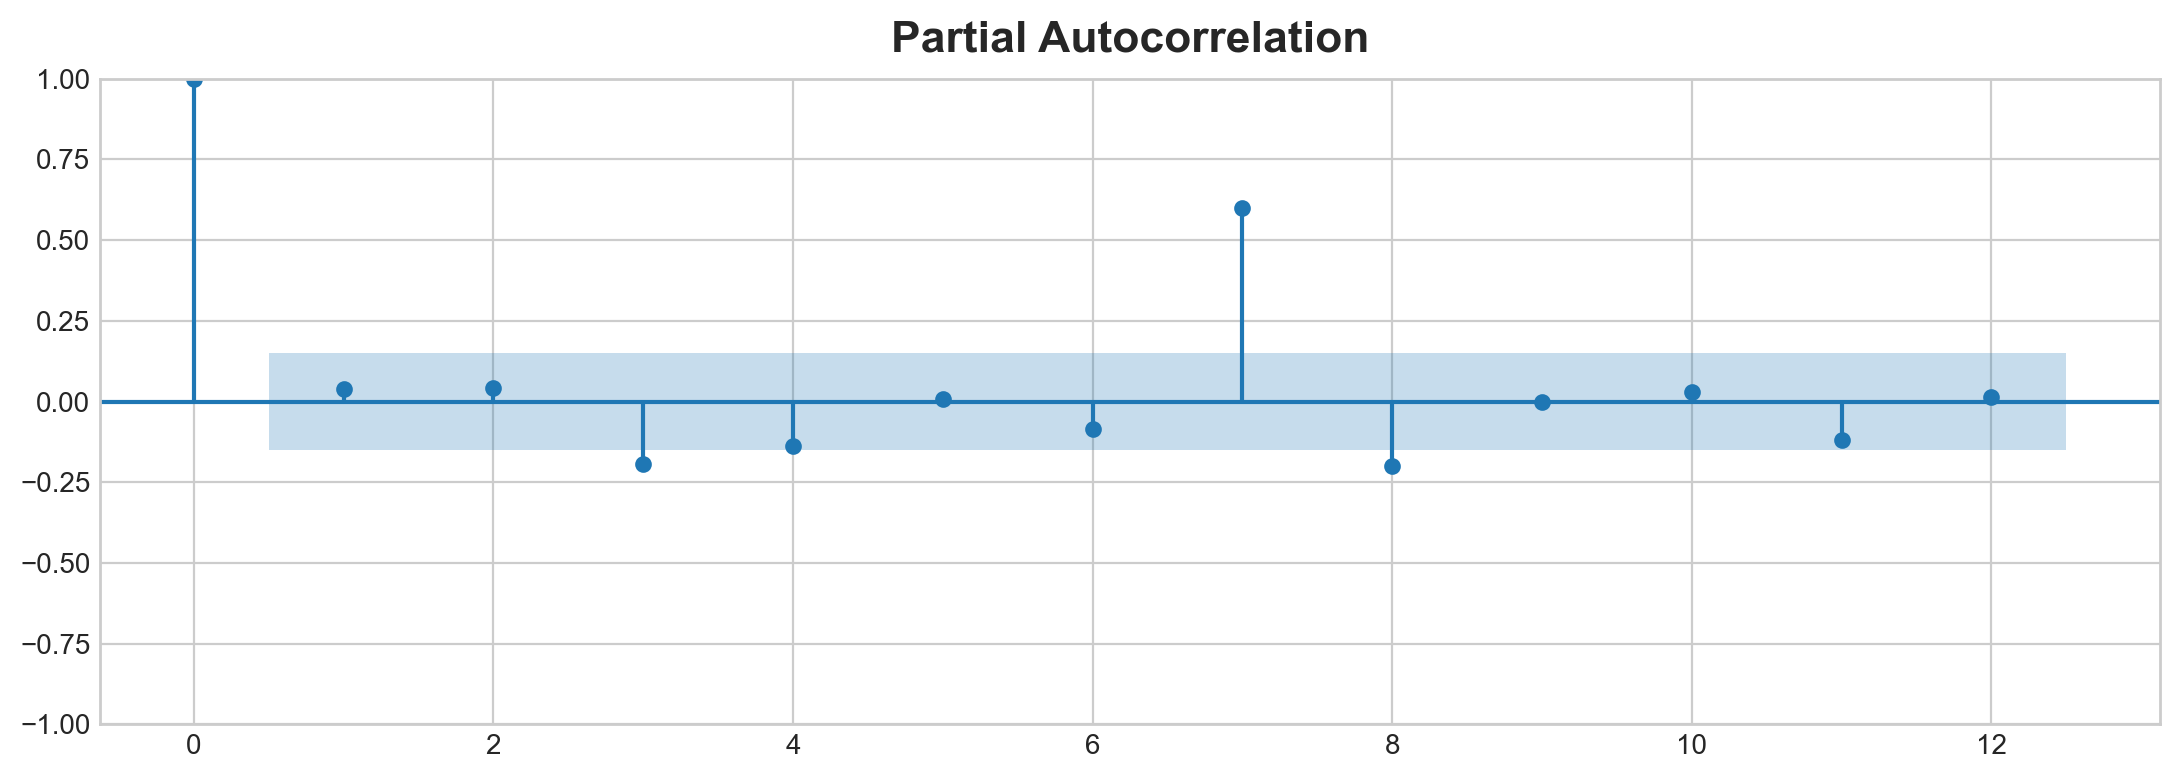

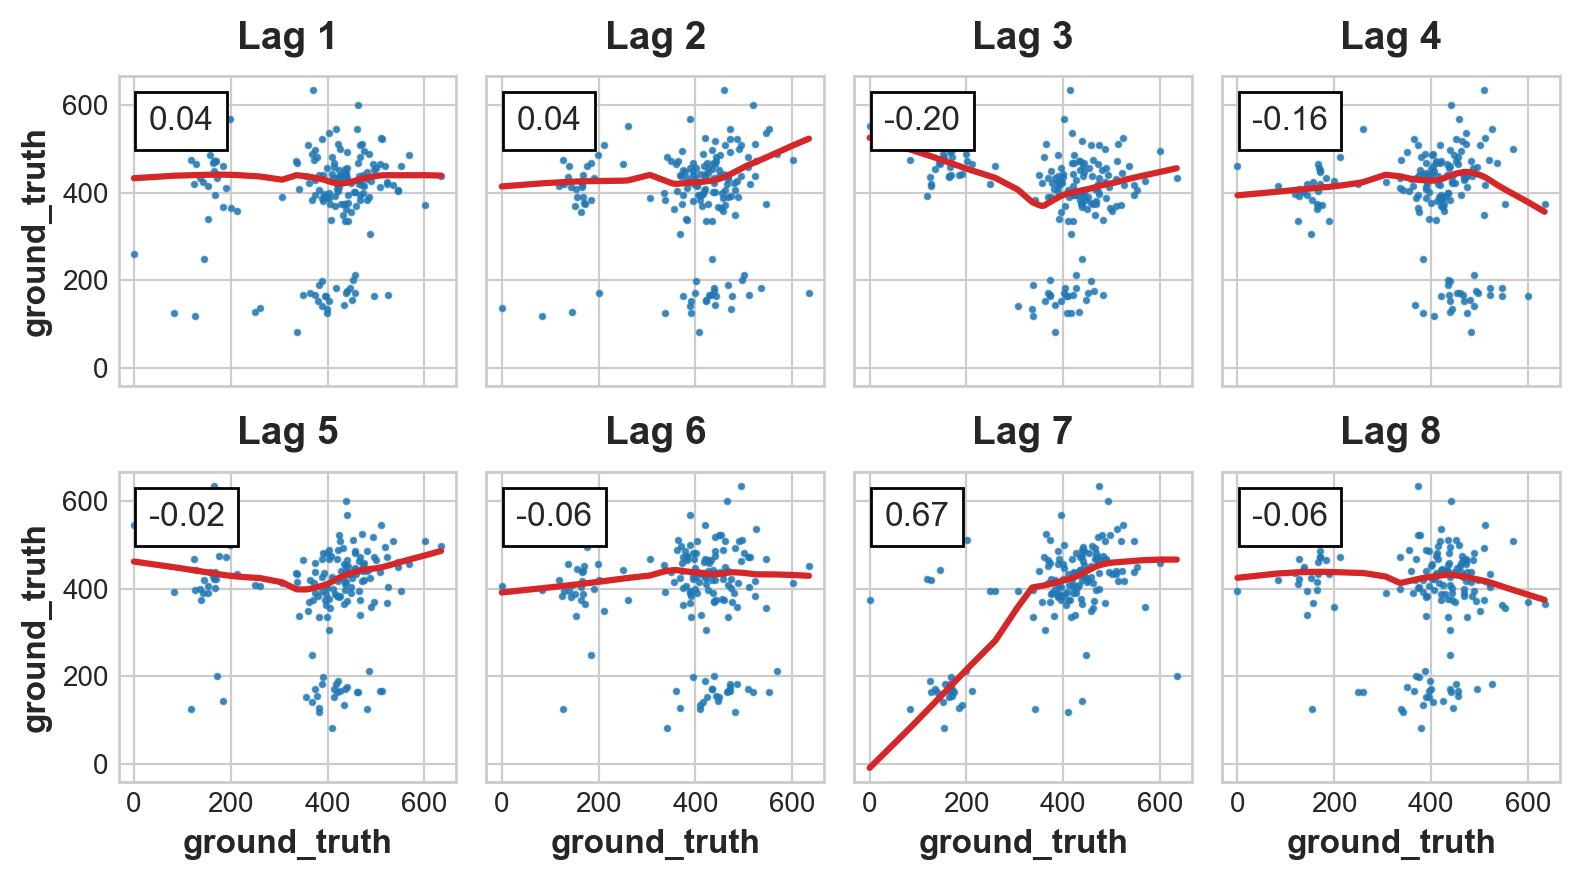

In [81]:
from statsmodels.graphics.tsaplots import plot_pacf
from learntools.time_series.utils import lagplot
from learntools.time_series.utils import plot_lags
_ = plot_pacf(y_true, lags = 12)
_ = plot_lags(y_true, lags = 8, nrows = 2)

### 9.2 X2 and X2_test Change

In [123]:
#Get X_merged to shift data well
X_merged = pd.concat([dtrain, dtest])
index_merged = X_merged.index.get_level_values(level = 0).unique() #get dates for the merged table
y_train_merged = X_merged['sales'].unstack(['family', 'store_nbr'])
X_merged

sales  onpromotion         id
date       family     store_nbr                               
2013-01-01 AUTOMOTIVE 1            0.0            0        NaN
                      10           0.0            0        NaN
                      11           0.0            0        NaN
                      12           0.0            0        NaN
                      13           0.0            0        NaN
...                                ...          ...        ...
2017-08-31 SEAFOOD    54           NaN            0  3029267.0
                      6            NaN            1  3029300.0
                      7            NaN            1  3029333.0
                      8            NaN            1  3029366.0
                      9            NaN            0  3029399.0

[3029400 rows x 3 columns]

In [135]:
#Sales Lags
sales_lags = X_merged['sales'].groupby(['family', 'store_nbr'], group_keys = False).apply(make_lags, lags = 3, name = 'sales').fillna(0.0)

In [136]:
#Onpromotion leads
onp_leads = X_merged['onpromotion'].groupby(['family', 'store_nbr'], group_keys = False).apply(make_leads, leads = 3, name = 'onpromotion').fillna(0.0)

In [159]:
#X2 whole
X2_whole = pd.concat([sales_lags, onp_leads], axis = 1)
X2_whole['family_fact'] = X2_whole.index.get_level_values(level = 1)
X2_whole['family_fact'] = le_family.fit_transform(X2_whole['family_fact'])
X2_whole['store_fact'] = X2_whole.index.get_level_values(level = 2).astype(int)
X2_whole

sales_lag_1  sales_lag_2  sales_lag_3  \
date       family     store_nbr                                          
2013-01-01 AUTOMOTIVE 1                  0.0          0.0          0.0   
                      10                 0.0          0.0          0.0   
                      11                 0.0          0.0          0.0   
                      12                 0.0          0.0          0.0   
                      13                 0.0          0.0          0.0   
...                                      ...          ...          ...   
2017-08-31 SEAFOOD    54                 0.0          0.0          0.0   
                      6                  0.0          0.0          0.0   
                      7                  0.0          0.0          0.0   
                      8                  0.0          0.0          0.0   
                      9                  0.0          0.0          0.0   

                                 onpromotion_lead_2  onpromotion_lead_1  \
date       family     store_nbr                                           
2013-01-01 AUTOMOTIVE 1                         0.0                 0.0   
                      10                        0.0                 0.0   
                      11                        0.0                 0.0   
                      12                        0.0                 0.0   
                      13                        0.0                 0.0   
...                                             ...                 ...   
2017-08-31 SEAFOOD    54                        0.0                 0.0   
                      6                         0.0                 0.0   
                      7                         0.0                 0.0   
                      8                         0.0                 0.0   
                      9                         0.0                 0.0   

                                 onpromotion_lead_0  family_fact  store_fact  
date       family     store_nbr                                               
2013-01-01 AUTOMOTIVE 1                           0            0           1  
                      10                          0            0          10  
                      11                          0            0          11  
                      12                          0            0          12  
                      13                          0            0          13  
...                                             ...          ...         ...  
2017-08-31 SEAFOOD    54                          0           32          54  
                      6                           1           32           6  
                      7                           1           32           7  
                      8                           1           32           8  
                      9                           0           32           9  

[3029400 rows x 8 columns]

In [161]:
#Seperate X2 and X2_test
X2_cycles = X2_whole.loc['2013-01-01':'2017-07-31']
X2_cycles_test = X2_whole.loc['2017-08-16':'2017-08-31']
X2_cycles_test

sales_lag_1  sales_lag_2  sales_lag_3  \
date       family     store_nbr                                          
2017-08-16 AUTOMOTIVE 1                  4.0          1.0          1.0   
                      10                 4.0          1.0          0.0   
                      11                 6.0          2.0          6.0   
                      12                 2.0          6.0         12.0   
                      13                 4.0          2.0          2.0   
...                                      ...          ...          ...   
2017-08-31 SEAFOOD    54                 0.0          0.0          0.0   
                      6                  0.0          0.0          0.0   
                      7                  0.0          0.0          0.0   
                      8                  0.0          0.0          0.0   
                      9                  0.0          0.0          0.0   

                                 onpromotion_lead_2  onpromotion_lead_1  \
date       family     store_nbr                                           
2017-08-16 AUTOMOTIVE 1                         0.0                 0.0   
                      10                        0.0                 0.0   
                      11                        0.0                 0.0   
                      12                        0.0                 0.0   
                      13                        0.0                 0.0   
...                                             ...                 ...   
2017-08-31 SEAFOOD    54                        0.0                 0.0   
                      6                         0.0                 0.0   
                      7                         0.0                 0.0   
                      8                         0.0                 0.0   
                      9                         0.0                 0.0   

                                 onpromotion_lead_0  family_fact  store_fact  
date       family     store_nbr                                               
2017-08-16 AUTOMOTIVE 1                           0            0           1  
                      10                          0            0          10  
                      11                          0            0          11  
                      12                          0            0          12  
                      13                          0            0          13  
...                                             ...          ...         ...  
2017-08-31 SEAFOOD    54                          0           32          54  
                      6                           1           32           6  
                      7                           1           32           7  
                      8                           1           32           8  
                      9                           0           32           9  

[28512 rows x 8 columns]

RMSLE: 0.00009


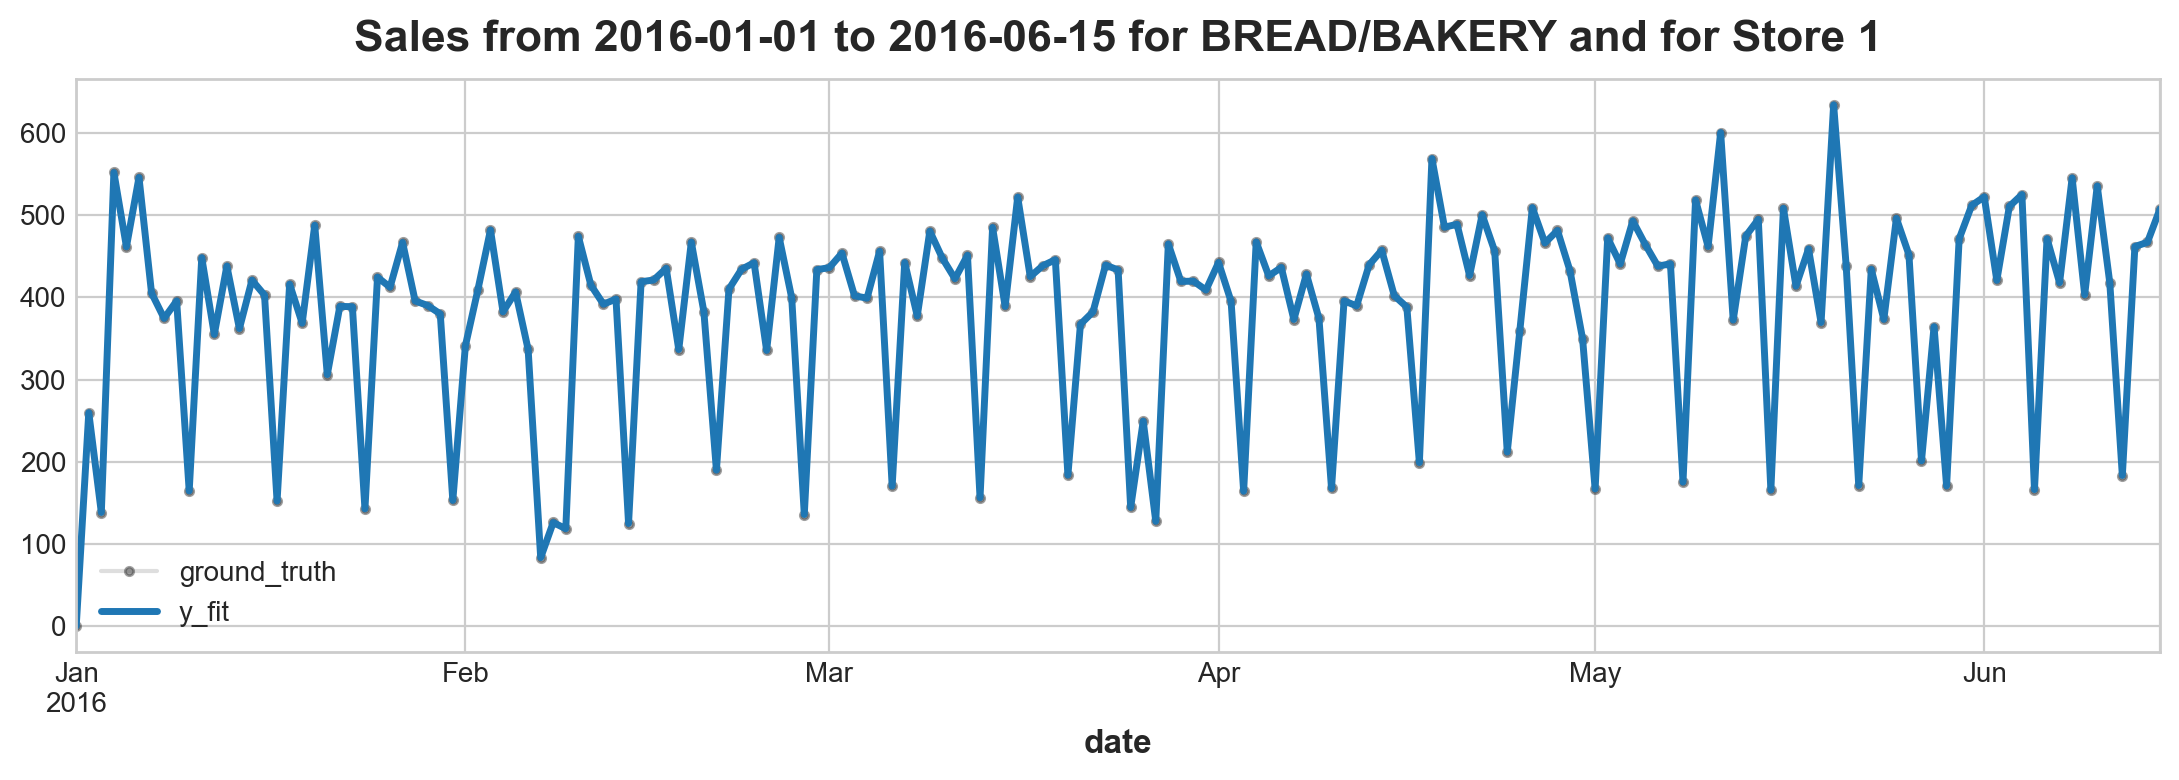

In [185]:
#Check
X2_cycles_wide = X2_cycles.unstack(['family', 'store_nbr'])
check(X2_cycles_wide, y = y_train, STORE = STORE, model = XGBRegressor())

### 9.3 Fit and Predict

In [164]:
#Class remains the same!
model_MBH.fit(X_volc_fin_multi, X2_cycles, y_train_multi)

In [169]:
#Predict
y_pred_cycles = model_MBH.predict(X_volcano_test, X2_cycles_test)
#Columns
y_pred_cycles = y_pred_cycles[['y_step_1', 'y_step_2', 'y_step_3', 'y_step_4', 'y_step_5', 'y_step_6', 'y_step_7', 'y_step_8', 
                         'y_step_9', 'y_step_10', 'y_step_11', 'y_step_12', 'y_step_13', 'y_step_14', 'y_step_15', 'y_step_16']]
ypc_wide = y_pred_cycles.unstack(['family' ,'store_nbr'])
ypc_wide

y_step_1                                                    \
family     AUTOMOTIVE                                                     
store_nbr           1   10        11        12        13        14   15   
2017-08-16   0.089364  0.0  3.720801  2.358592  2.732912  0.000000  0.0   
2017-08-17   0.273268  0.0  3.396793  2.150462  1.938203  0.000000  0.0   
2017-08-18   0.614223  0.0  2.868137  1.506918  1.454352  0.000000  0.0   
2017-08-19   0.383353  0.0  3.796308  2.182691  2.036176  0.000000  0.0   
2017-08-20   0.282815  0.0  4.223591  2.618122  2.572993  0.000000  0.0   
2017-08-21   0.000000  0.0  4.290331  2.765140  2.589534  0.000000  0.0   
2017-08-22   0.000000  0.0  4.076232  2.765252  2.988121  0.000000  0.0   
2017-08-23   0.000000  0.0  3.726422  2.439505  2.980962  0.000000  0.0   
2017-08-24   0.185913  0.0  3.423358  2.197783  2.187984  0.000000  0.0   
2017-08-25   0.570087  0.0  2.907311  1.521084  1.701770  0.000000  0.0   
2017-08-26   0.382074  0.0  3.839120  2.164583  2.276471  0.000000  0.0   
2017-08-27   0.323069  0.0  4.260701  2.569014  2.800869  0.000000  0.0   
2017-08-28   0.000000  0.0  4.312301  2.686644  2.799316  0.000000  0.0   
2017-08-29   0.012518  0.0  4.073806  2.659265  3.173933  0.119273  0.0   
2017-08-30   0.107392  0.0  3.690800  2.308156  3.136923  0.000000  0.0   
2017-08-31   0.361587  0.0  3.346453  2.043384  2.308419  0.000000  0.0   

                                     ...  y_step_16                        \
family                               ...    SEAFOOD                         
store_nbr         16        17   18  ...          5         50         51   
2017-08-16  0.000000  6.084748  0.0  ...  11.637913  19.286589  52.682453   
2017-08-17  0.000000  5.355596  0.0  ...  10.817117  17.304212  51.800623   
2017-08-18  0.000000  4.493920  0.0  ...  10.616967  17.872489  54.816143   
2017-08-19  0.000000  5.205289  0.0  ...  11.013224  19.213547  61.484024   
2017-08-20  0.000000  5.624963  0.0  ...  10.990056  19.403826  61.333235   
2017-08-21  0.049037  5.424455  0.0  ...  11.027412  21.005780  63.216430   
2017-08-22  0.042531  5.295713  0.0  ...   9.878611  20.480985  58.004959   
2017-08-23  0.302814  5.317150  0.0  ...  10.825486  19.591318  52.831711   
2017-08-24  0.223385  4.613592  0.0  ...  10.113996  17.824778  52.173916   
2017-08-25  0.000000  3.789408  0.0  ...  10.023089  18.601209  55.408617   
2017-08-26  0.000000  4.548698  0.0  ...  10.526177  20.138844  62.283015   
2017-08-27  0.010658  5.025058  0.0  ...  10.605296  20.510454  62.318530   
2017-08-28  0.431980  4.888193  0.0  ...  10.738532  22.275115  64.360761   
2017-08-29  0.370176  4.828153  0.0  ...   9.677654  21.891381  59.274693   
2017-08-30  0.570165  4.921412  0.0  ...  10.703275  21.118512  54.187725   
2017-08-31  0.426990  4.290872  0.0  ...  10.060495  19.442345  53.572634   

                                                                           \
family                                                                      
store_nbr         52        53        54          6          7          8   
2017-08-16  2.386277  7.290844  1.920818  49.312273  63.824443  50.467913   
2017-08-17  2.505443  7.601063  1.883910  45.447115  65.738171  50.086451   
2017-08-18  2.751742  8.239507  1.982311  46.582621  67.397167  54.410852   
2017-08-19  2.633847  8.387813  1.818131  53.157913  65.626298  59.694996   
2017-08-20  2.463434  8.758023  2.100641  54.940006  64.831298  61.711966   
2017-08-21  2.660081  8.194074  2.000793  54.918773  63.865496  62.984954   
2017-08-22  2.399109  7.542746  2.180205  55.386557  65.038146  58.831977   
2017-08-23  2.468127  6.952896  1.668570  50.181010  64.452126  51.340946   
2017-08-24  2.622873  7.302494  1.643174  46.337817  66.091643  50.788915   
2017-08-25  2.898483  7.986801  1.756501  47.506159  67.536929  54.976994   
2017-08-26  2.803233  8.186301  1.610659  54.122707  65.612213  60.160347   
2017-08-27  2.648576  8.611760  1.914865  55.

In [172]:
#Forecast
forecast10 = fetch_forecast(ypc_wide)
#Output
output10 = make_output(forecast10)
output10.to_csv('sales_predictions10.csv')